# Análisis de EEG No Supervisado (ANS)

In [1]:
from sklearn.impute import SimpleImputer
from sklearn.cluster import DBSCAN, KMeans
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, silhouette_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import OPTICS, MeanShift, SpectralClustering
from sklearn.mixture import GaussianMixture
from yellowbrick.cluster import KElbowVisualizer


## Cargar datos y EDA

In [2]:
df = pd.read_csv("/Users/luciarebolledo/PycharmProjects/TFG_practicas_final/eeg_features_session01_binarias/eeg_features_4.csv")

In [119]:
print("Primeras filas del CSV:")
print(df.head(35))

Primeras filas del CSV:
    epoch  window  n_samples   Start_w     End_w  Trust Binary_Trust  \
0       1       1         37  0.000000  0.144531    NaN          NaN   
1       1       2         37  0.070312  0.214844    NaN          NaN   
2       1       3         37  0.140625  0.285156    NaN          NaN   
3       1       4         37  0.210938  0.355469    NaN          NaN   
4       1       5         37  0.281250  0.425781    NaN          NaN   
5       1       6         37  0.351562  0.496094    NaN          NaN   
6       1       7         37  0.421875  0.566406    NaN          NaN   
7       1       8         37  0.492188  0.636719    NaN          NaN   
8       1       9         37  0.562500  0.707031    NaN          NaN   
9       1      10         37  0.648438  0.792969    NaN          NaN   
10      2       1          9  0.796870  0.832026    2.0   high_trust   
11      2       2          9  0.816401  0.851557    2.0   high_trust   
12      2       3          9  0.835932  

In [120]:
print("\nEstadísticas de las variables numéricas:")
print(df.describe())


Estadísticas de las variables numéricas:
             epoch       window    n_samples      Start_w        End_w  \
count  2320.000000  2320.000000  2320.000000  2320.000000  2320.000000   
mean    116.500000     5.500000    75.478017   196.767394   197.062164   
std      66.986447     2.872901   105.069748   106.608501   106.569030   
min       1.000000     1.000000     6.000000     0.000000     0.144531   
25%      58.750000     3.000000    37.000000   125.289620   125.899971   
50%     116.500000     5.500000    53.000000   209.597170   210.183108   
75%     174.250000     8.000000   117.000000   290.467453   290.859054   
max     232.000000    10.000000  1371.000000   365.381558   365.756558   

             Trust  ch1-Delta-DE  ch1-Delta-PSD  ch1-Delta-Mean  \
count  2000.000000   2320.000000   2.320000e+03     2320.000000   
mean      1.925000     -0.057409   1.697903e+00       -0.030520   
std       1.034365      2.290557   4.204709e+00        1.289302   
min       1.000000     

In [121]:
print("\nInformación general del CSV:")
print(df.info())


Información general del CSV:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2320 entries, 0 to 2319
Columns: 1261 entries, epoch to ch19-LowGamma-HjComp
dtypes: float64(1257), int64(3), object(1)
memory usage: 22.3+ MB
None


In [122]:
# Mostrar nombres de las columnas
print("Columnas disponibles en el CSV:")
print(df.columns.tolist())

Columnas disponibles en el CSV:
['epoch', 'window', 'n_samples', 'Start_w', 'End_w', 'Trust', 'Binary_Trust', 'ch1-Delta-DE', 'ch1-Delta-PSD', 'ch1-Delta-Mean', 'ch1-Delta-Std', 'ch1-Delta-PeakToPeak', 'ch1-Delta-Skew', 'ch1-Delta-Kurt', 'ch1-Delta-RelPow', 'ch1-Delta-HjAct', 'ch1-Delta-HjMob', 'ch1-Delta-HjComp', 'ch1-Theta-DE', 'ch1-Theta-PSD', 'ch1-Theta-Mean', 'ch1-Theta-Std', 'ch1-Theta-PeakToPeak', 'ch1-Theta-Skew', 'ch1-Theta-Kurt', 'ch1-Theta-RelPow', 'ch1-Theta-HjAct', 'ch1-Theta-HjMob', 'ch1-Theta-HjComp', 'ch1-Alpha-DE', 'ch1-Alpha-PSD', 'ch1-Alpha-Mean', 'ch1-Alpha-Std', 'ch1-Alpha-PeakToPeak', 'ch1-Alpha-Skew', 'ch1-Alpha-Kurt', 'ch1-Alpha-RelPow', 'ch1-Alpha-HjAct', 'ch1-Alpha-HjMob', 'ch1-Alpha-HjComp', 'ch1-Sigma-DE', 'ch1-Sigma-PSD', 'ch1-Sigma-Mean', 'ch1-Sigma-Std', 'ch1-Sigma-PeakToPeak', 'ch1-Sigma-Skew', 'ch1-Sigma-Kurt', 'ch1-Sigma-RelPow', 'ch1-Sigma-HjAct', 'ch1-Sigma-HjMob', 'ch1-Sigma-HjComp', 'ch1-Beta-DE', 'ch1-Beta-PSD', 'ch1-Beta-Mean', 'ch1-Beta-Std', 'c

In [123]:
# Ver cuántas épocas distintas hay
num_epocas = df['epoch'].nunique()
print("Número de épocas:", num_epocas)

# Ver los nombres/números de todas las épocas
epocas = df['epoch'].unique()
print("Épocas:", epocas)


Número de épocas: 232
Épocas: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232]


In [124]:
# Ver cuantos nulos 
nan_rows = df[df.isna().any(axis=1)]
print(nan_rows)


      epoch  window  n_samples     Start_w       End_w  Trust Binary_Trust  \
0         1       1         37    0.000000    0.144531    NaN          NaN   
1         1       2         37    0.070312    0.214844    NaN          NaN   
2         1       3         37    0.140625    0.285156    NaN          NaN   
3         1       4         37    0.210938    0.355469    NaN          NaN   
4         1       5         37    0.281250    0.425781    NaN          NaN   
...     ...     ...        ...         ...         ...    ...          ...   
2315    232       6         96  364.662808  365.037808    NaN          NaN   
2316    232       7         96  364.842495  365.217495    NaN          NaN   
2317    232       8         96  365.022183  365.397183    NaN          NaN   
2318    232       9         96  365.201870  365.576870    NaN          NaN   
2319    232      10         96  365.381558  365.756558    NaN          NaN   

      ch1-Delta-DE  ch1-Delta-PSD  ch1-Delta-Mean  ...  ch19-Lo

In [125]:
nan_counts = df.isna().sum()
print(nan_counts[nan_counts > 0])


Trust           320
Binary_Trust    320
dtype: int64


### Correlación con Binary_Trust

In [126]:
# Filtrar filas con target no nulo
# Convertir a 0/1
df_valid = df[df['Binary_Trust'].notna()].copy()
df_valid['Binary_Trust_num'] = df_valid['Binary_Trust'].map({'low_trust': 0, 'high_trust': 1})


# Seleccionar solo las columnas ch...
features = [col for col in df_valid.columns if col.startswith('ch')]

# Correlación con Binary_Trust
corr = df_valid[features].corrwith(df_valid['Binary_Trust_num'])

# Ordenamos de mayor a menor en valor absoluto
corr_sorted = corr.reindex(corr.abs().sort_values(ascending=False).index)

# Mostramos las 10 más correlacionadas
print("Top 10 features correlacionadas con Binary_Trust:")
print(corr_sorted.head(10))


Top 10 features correlacionadas con Binary_Trust:
ch9-LowGamma-Std            0.219705
ch9-LowGamma-PeakToPeak     0.216443
ch8-LowGamma-Std            0.212179
ch9-LowGamma-DE             0.199960
ch8-LowGamma-PeakToPeak     0.195065
ch14-LowGamma-PeakToPeak    0.192126
ch8-LowGamma-HjAct          0.190125
ch9-LowGamma-HjAct          0.187471
ch14-LowGamma-Std           0.186777
ch14-LowGamma-HjAct         0.174129
dtype: float64


## Clustering por Ventanas

### KMeans con 2 clusters

In [5]:
df_clustering = df.copy()

#### Variables mas relevantes segun HST-3

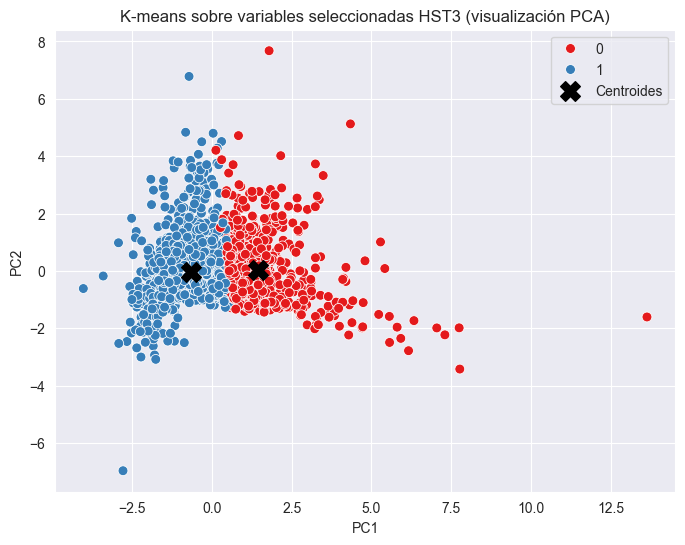

Silhouette Score: 0.2260
Adjusted Rand Index: 0.0014
Adjusted Mutual Info: 0.0013
         ch7-LowGamma-HjComp  ch7-Theta-Std  ch7-Alpha-Kurt  \
cluster                                                       
0                   1.065859       4.150089        0.094612   
1                   1.070755       1.180414       -0.615672   

         ch4-LowGamma-HjComp  ch4-Theta-Std  ch4-Alpha-Kurt  
cluster                                                      
0                   1.083182       2.591307       -0.354266  
1                   1.101466       0.626030       -0.565267  


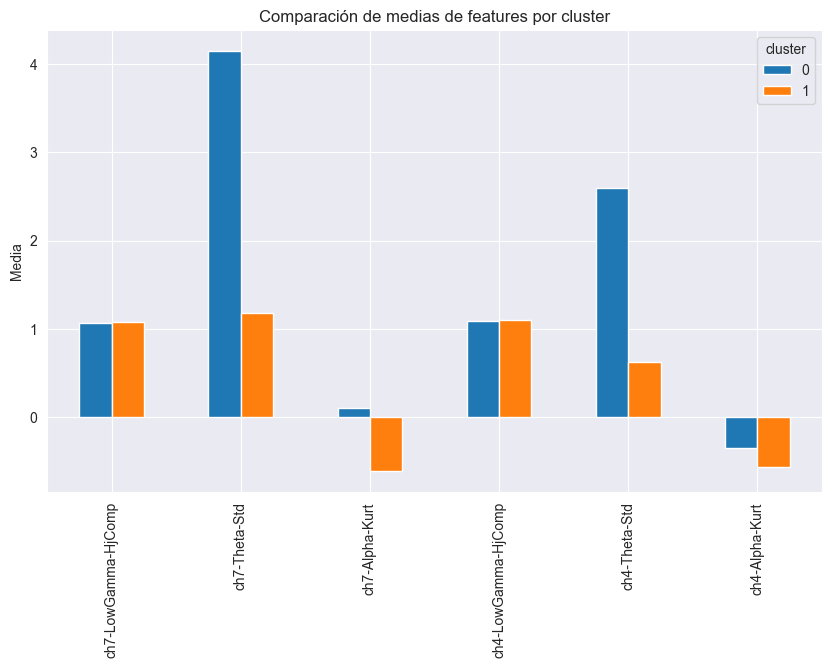

In [142]:
# 1. Selección de features HST3

selected_features = [
    'ch7-LowGamma-HjComp', 'ch7-Theta-Std', 'ch7-Alpha-Kurt',  # P7
    'ch4-LowGamma-HjComp', 'ch4-Theta-Std', 'ch4-Alpha-Kurt'   # P4
]

# Crear copia para no modificar el original
df_subset = df_clustering[selected_features].copy()


# 2. Escalado
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_subset)


# 3. KMeans clustering
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Guardar clusters en df_subset
df_subset['cluster'] = clusters


# 4. PCA para visualización
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

df_vis = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_vis['cluster'] = clusters


# 5. Visualización de clusters y centroides
plt.figure(figsize=(8,6))
sns.scatterplot(data=df_vis, x='PC1', y='PC2', hue='cluster', palette='Set1', s=50)

# Centroides en espacio PCA
centroids_pca = pca.transform(kmeans.cluster_centers_)
plt.scatter(centroids_pca[:,0], centroids_pca[:,1], c='black', s=200, marker='X', label='Centroides')

plt.title('K-means sobre variables seleccionadas HST3 (visualización PCA)')
plt.legend()
plt.show()


# 6. Comparación con Binary_Trust
# Filtrar filas válidas
mask = df['Binary_Trust'].notna()
y_valid = df.loc[mask, 'Binary_Trust']

# Ajustar a 0/1 si quieres métricas numéricas
y_valid_num = y_valid.map({'low_trust': 0, 'high_trust': 1})

clusters_valid = df_subset.loc[mask, 'cluster']

# Métricas
ari = adjusted_rand_score(y_valid_num, clusters_valid)
ami = adjusted_mutual_info_score(y_valid_num, clusters_valid)
sil_score = silhouette_score(X_scaled, clusters)

print(f'Silhouette Score: {sil_score:.4f}')
print(f'Adjusted Rand Index: {ari:.4f}')
print(f'Adjusted Mutual Info: {ami:.4f}')


# 7. Análisis de centroides
centroides = df_subset.groupby('cluster').mean()
print(centroides)

centroides.T.plot(kind='bar', figsize=(10,6))
plt.title("Comparación de medias de features por cluster")
plt.ylabel("Media")
plt.show()


#### K-means con todas las variables ch... (escaladas)

In [ ]:
# 1. Selección de todas las columnas "ch..."
selected_features = [col for col in df.columns if col.startswith('ch')]
df_subset = df[selected_features].copy()

# 2. Escalado
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_subset)

# 3. KMeans clustering
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X_scaled)
df_subset['cluster'] = clusters


# 4. PCA para visualización
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

df_vis = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_vis['cluster'] = clusters

plt.figure(figsize=(8,6))
sns.scatterplot(data=df_vis, x='PC1', y='PC2', hue='cluster', palette='Set1', s=50)

# Centroides
centroids_pca = pca.transform(kmeans.cluster_centers_)
plt.scatter(centroids_pca[:,0], centroids_pca[:,1], c='black', s=200, marker='X', label='Centroides')

plt.title('K-means sobre todas las variables ch... (visualización PCA)')
plt.legend()
plt.show()


# 5. Métricas
mask = df['Binary_Trust'].notna()
y_valid = df.loc[mask, 'Binary_Trust'].map({'low_trust': 0, 'high_trust': 1})
clusters_valid = df_subset.loc[mask, 'cluster']

sil_score = silhouette_score(X_scaled, clusters)
ari = adjusted_rand_score(y_valid, clusters_valid)
ami = adjusted_mutual_info_score(y_valid, clusters_valid)

print(f'Silhouette Score: {sil_score:.4f}')
print(f'Adjusted Rand Index: {ari:.4f}')
print(f'Adjusted Mutual Info: {ami:.4f}')


# 6. Análisis de centroides
centroides = df_subset.groupby('cluster').mean()
print(centroides)

# Filtrar features con diferencia significativa entre clusters
diff = centroides.max(axis=0) - centroides.min(axis=0)
threshold = 0.2  # ajustar según lo que consideres relevante
important_features = diff[diff > threshold].index

# Gráficos por chunks si hay muchas features
chunk_size = 15
n_features = len(important_features)

for i in range(0, n_features, chunk_size):
    chunk = important_features[i:i+chunk_size]
    centroides[chunk].T.plot(kind='bar', figsize=(12,6))
    plt.title(f"Comparación de medias de features importantes por cluster (features {i+1} a {min(i+chunk_size, n_features)})")
    plt.ylabel("Media (feature escalada)")
    plt.xlabel("Features")
    plt.tight_layout()
    plt.show()


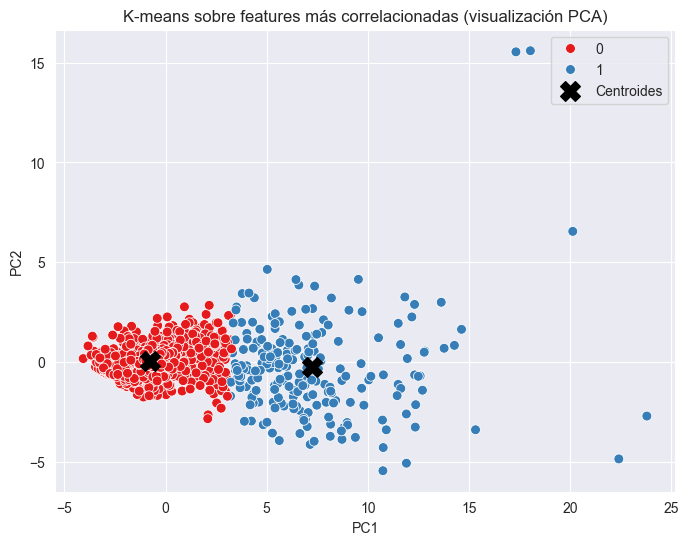

Silhouette Score: 0.7402
Adjusted Rand Index: 0.0124
Adjusted Mutual Info: 0.0375
         ch9-LowGamma-Std  ch9-LowGamma-PeakToPeak  ch8-LowGamma-Std  \
cluster                                                                
0                1.690311                 7.854946          2.357036   
1                6.637143                37.232197          5.922936   

         ch9-LowGamma-DE  ch8-LowGamma-PeakToPeak  ch14-LowGamma-PeakToPeak  \
cluster                                                                       
0               1.850666                10.886375                  7.456674   
1               3.211058                31.720699                 27.536020   

         ch8-LowGamma-HjAct  ch9-LowGamma-HjAct  ch14-LowGamma-Std  \
cluster                                                              
0                  6.349486            3.384252           1.622308   
1                 39.335988           48.341799           5.008795   

         ch14-LowGamma-HjAct  


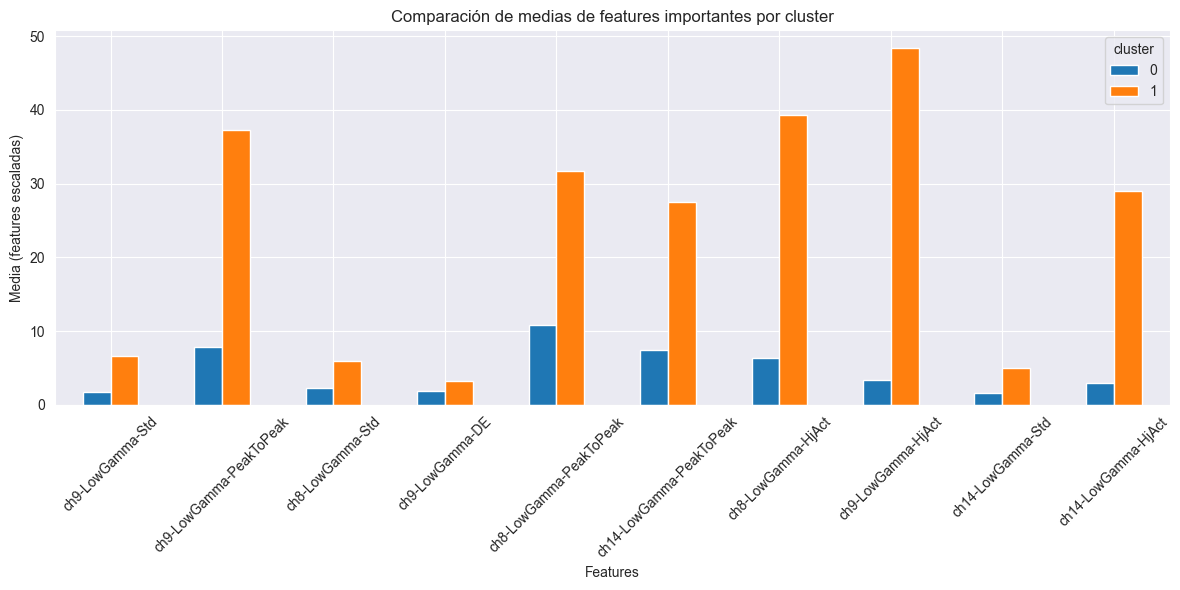

In [145]:
# 1. Selección de features más correlacionadas
selected_features = [
    'ch9-LowGamma-Std', 'ch9-LowGamma-PeakToPeak', 'ch8-LowGamma-Std',  
    'ch9-LowGamma-DE', 'ch8-LowGamma-PeakToPeak', 'ch14-LowGamma-PeakToPeak',
    'ch8-LowGamma-HjAct', 'ch9-LowGamma-HjAct', 'ch14-LowGamma-Std', 'ch14-LowGamma-HjAct'
]

df_subset = df[selected_features].copy()


# 2. Escalado de features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_subset)


# 3. KMeans clustering
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X_scaled)
df_subset['cluster'] = clusters


# 4. PCA para visualización
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

df_vis = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_vis['cluster'] = clusters

plt.figure(figsize=(8,6))
sns.scatterplot(data=df_vis, x='PC1', y='PC2', hue='cluster', palette='Set1', s=50)

# Centroides en PCA
centroids_pca = pca.transform(kmeans.cluster_centers_)
plt.scatter(centroids_pca[:,0], centroids_pca[:,1], c='black', s=200, marker='X', label='Centroides')

plt.title('K-means sobre features más correlacionadas (visualización PCA)')
plt.legend()
plt.show()


# 5. Métricas

sil_score = silhouette_score(X_scaled, clusters)
print(f'Silhouette Score: {sil_score:.4f}')

mask = df['Binary_Trust'].notna()
y_valid = df.loc[mask, 'Binary_Trust'].map({'low_trust':0, 'high_trust':1})
clusters_valid = df_subset.loc[mask, 'cluster']

ari = adjusted_rand_score(y_valid, clusters_valid)
ami = adjusted_mutual_info_score(y_valid, clusters_valid)

print(f'Adjusted Rand Index: {ari:.4f}')
print(f'Adjusted Mutual Info: {ami:.4f}')


# 6. Análisis de centroides

centroides = df_subset.groupby('cluster').mean()
print(centroides)

# Filtrar features con diferencia significativa entre clusters
diff = centroides.max(axis=0) - centroides.min(axis=0)
threshold = 0  # cambiar si quieres filtrar
important_features = diff[diff > threshold].index

centroides[important_features].T.plot(kind='bar', figsize=(12,6))
plt.title("Comparación de medias de features importantes por cluster")
plt.ylabel("Media (features escaladas)")
plt.xlabel("Features")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


#### Correlacionadas con Binary_Trust 

### CARCATERISTICAS USADAS 30%

Se van a usar 376 features


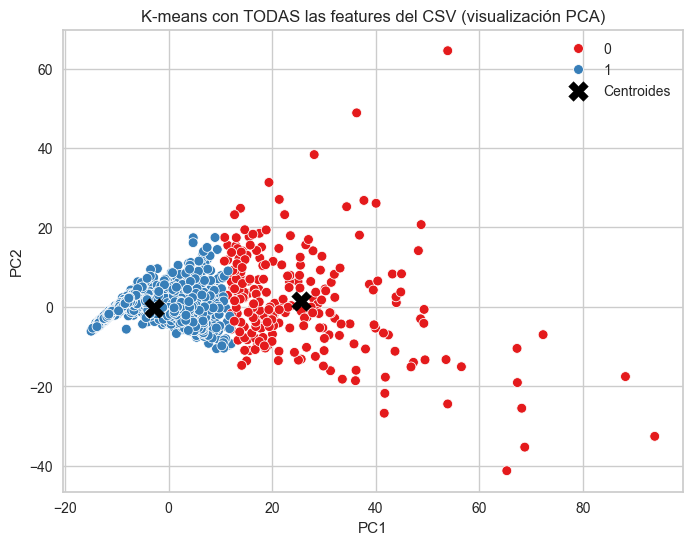

Silhouette Score: 0.5628
Adjusted Rand Index: 0.0090
Adjusted Mutual Info: 0.0244


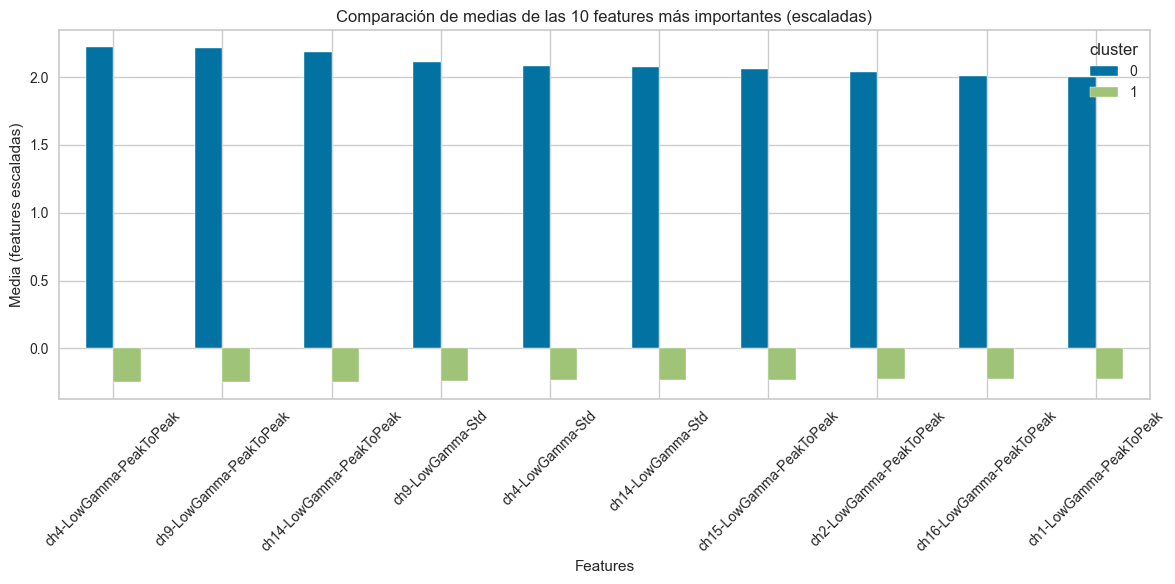

Centroides escalados (top 10 features):
         ch4-LowGamma-PeakToPeak  ch9-LowGamma-PeakToPeak  \
cluster                                                     
0                          2.220                    2.212   
1                         -0.249                   -0.248   

         ch14-LowGamma-PeakToPeak  ch9-LowGamma-Std  ch4-LowGamma-Std  \
cluster                                                                 
0                           2.188             2.111             2.085   
1                          -0.245            -0.237            -0.234   

         ch14-LowGamma-Std  ch15-LowGamma-PeakToPeak  ch2-LowGamma-PeakToPeak  \
cluster                                                                         
0                    2.075                     2.058                    2.034   
1                   -0.233                    -0.231                   -0.228   

         ch16-LowGamma-PeakToPeak  ch1-LowGamma-PeakToPeak  
cluster                             

In [6]:


# 1. Cargar lista de features y seleccionar subset

features30 = pd.read_csv("/Users/luciarebolledo/PycharmProjects/TFG_practicas_final/top30_features_eeg_session01.csv")
all_features = features30["feature"].tolist()
print(f"Se van a usar {len(all_features)} features")

# Seleccionamos solo esas columnas de df_clustering
df_subset = df_clustering[all_features].copy()


# 2. Escalado de features

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_subset)

# Convertimos a DataFrame para mantener nombres de columnas
df_scaled = pd.DataFrame(X_scaled, columns=all_features)


# 3. KMeans con 2 clusters

kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X_scaled)
df_scaled['cluster'] = clusters 


# 4. PCA para visualización

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

df_vis = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
df_vis["cluster"] = clusters


# 5. Scatter plot con PCA y centroides

plt.figure(figsize=(8,6))
sns.scatterplot(data=df_vis, x="PC1", y="PC2", hue="cluster", palette="Set1", s=50)

# Centroides proyectados en PCA
centroids_pca = pca.transform(kmeans.cluster_centers_)
plt.scatter(centroids_pca[:,0], centroids_pca[:,1], c="black", s=200, marker="X", label="Centroides")

plt.title("K-means con TODAS las features del CSV (visualización PCA)")
plt.legend()
plt.show()


# 6. Métrica de Silhouette

sil = silhouette_score(X_scaled, clusters)
print(f"Silhouette Score: {sil:.4f}")


# 7. Comparación con Binary_Trust (opcional)

df_valid = df[df['Binary_Trust'].notna()].copy()
df_valid['Binary_Trust_num'] = df_valid['Binary_Trust'].map({'low_trust': 0, 'high_trust': 1})
clusters_valid = clusters[df_valid.index.to_list()]

ari = adjusted_rand_score(df_valid['Binary_Trust_num'], clusters_valid)
ami = adjusted_mutual_info_score(df_valid['Binary_Trust_num'], clusters_valid)

print(f'Adjusted Rand Index: {ari:.4f}')
print(f'Adjusted Mutual Info: {ami:.4f}')


# 8. Análisis de centroides y selección de top 10 features importantes

centroides_scaled = df_scaled.groupby('cluster').mean()

# Diferencia máxima por feature entre clusters
diff = centroides_scaled.max(axis=0) - centroides_scaled.min(axis=0)
important_features = diff.sort_values(ascending=False).index[:10]  

# Graficar top 10 features
centroides_scaled[important_features].T.plot(kind='bar', figsize=(12,6))
plt.title("Comparación de medias de las 10 features más importantes (escaladas)")
plt.ylabel("Media (features escaladas)")
plt.xlabel("Features")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Mostrar los valores exactos de los centroides top 10
print("Centroides escalados (top 10 features):")
print(centroides_scaled[important_features].round(3))


## Agruparlo por epocas

In [7]:
## Agrupación por épocas y clustering optimizado

# 1. Agrupar por época: media de cada feature en todas sus ventanas

features = [col for col in df.columns if col.startswith("ch")]
df_epoch = df.groupby("epoch")[features].mean().reset_index()

# Llevar también el target
df_target = df.groupby("epoch")["Binary_Trust"].first().reset_index()
df_epoch = df_epoch.merge(df_target, on="epoch", how="left")


# 2. Imputación y escalado

imputer = SimpleImputer(strategy="mean")
X_imputed = imputer.fit_transform(df_epoch[features])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)


# 3. (Opcional) PCA para reducción de ruido

pca = PCA(n_components=0.95, random_state=42)  
X_pca = pca.fit_transform(X_scaled)


# 4. K-Means clustering

kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_pca)

# 5. Silhouette Score

sil = silhouette_score(X_pca, clusters)
print(f"Silhouette Score (épocas): {sil:.4f}")


# 6. Comparación con Binary_Trust

df_valid = df_epoch[df_epoch["Binary_Trust"].notna()].copy()
df_valid["Binary_Trust_num"] = df_valid["Binary_Trust"].map({"low_trust": 0, "high_trust": 1})

clusters_valid = clusters[df_valid.index.to_numpy()]

ari = adjusted_rand_score(df_valid["Binary_Trust_num"], clusters_valid)
ami = adjusted_mutual_info_score(df_valid["Binary_Trust_num"], clusters_valid)

print(f"Adjusted Rand Index (épocas): {ari:.4f}")
print(f"Adjusted Mutual Info (épocas): {ami:.4f}")


Silhouette Score (épocas): 0.3737
Adjusted Rand Index (épocas): -0.0035
Adjusted Mutual Info (épocas): -0.0042


In [105]:
print(df.columns.tolist())


['epoch', 'window', 'n_samples', 'Start_w', 'End_w', 'Trust', 'Binary_Trust', 'ch1-Delta-DE', 'ch1-Delta-PSD', 'ch1-Delta-Mean', 'ch1-Delta-Std', 'ch1-Delta-PeakToPeak', 'ch1-Delta-Skew', 'ch1-Delta-Kurt', 'ch1-Delta-RelPow', 'ch1-Delta-HjAct', 'ch1-Delta-HjMob', 'ch1-Delta-HjComp', 'ch1-Theta-DE', 'ch1-Theta-PSD', 'ch1-Theta-Mean', 'ch1-Theta-Std', 'ch1-Theta-PeakToPeak', 'ch1-Theta-Skew', 'ch1-Theta-Kurt', 'ch1-Theta-RelPow', 'ch1-Theta-HjAct', 'ch1-Theta-HjMob', 'ch1-Theta-HjComp', 'ch1-Alpha-DE', 'ch1-Alpha-PSD', 'ch1-Alpha-Mean', 'ch1-Alpha-Std', 'ch1-Alpha-PeakToPeak', 'ch1-Alpha-Skew', 'ch1-Alpha-Kurt', 'ch1-Alpha-RelPow', 'ch1-Alpha-HjAct', 'ch1-Alpha-HjMob', 'ch1-Alpha-HjComp', 'ch1-Sigma-DE', 'ch1-Sigma-PSD', 'ch1-Sigma-Mean', 'ch1-Sigma-Std', 'ch1-Sigma-PeakToPeak', 'ch1-Sigma-Skew', 'ch1-Sigma-Kurt', 'ch1-Sigma-RelPow', 'ch1-Sigma-HjAct', 'ch1-Sigma-HjMob', 'ch1-Sigma-HjComp', 'ch1-Beta-DE', 'ch1-Beta-PSD', 'ch1-Beta-Mean', 'ch1-Beta-Std', 'ch1-Beta-PeakToPeak', 'ch1-Beta-S

In [104]:
print("Primeras filas del CSV:")
print(df.head(35))

Primeras filas del CSV:
    epoch  window  n_samples   Start_w     End_w  Trust Binary_Trust  \
0       1       1         37  0.000000  0.144531    NaN          NaN   
1       1       2         37  0.070312  0.214844    NaN          NaN   
2       1       3         37  0.140625  0.285156    NaN          NaN   
3       1       4         37  0.210938  0.355469    NaN          NaN   
4       1       5         37  0.281250  0.425781    NaN          NaN   
5       1       6         37  0.351562  0.496094    NaN          NaN   
6       1       7         37  0.421875  0.566406    NaN          NaN   
7       1       8         37  0.492188  0.636719    NaN          NaN   
8       1       9         37  0.562500  0.707031    NaN          NaN   
9       1      10         37  0.648438  0.792969    NaN          NaN   
10      2       1          9  0.796870  0.832026    2.0   high_trust   
11      2       2          9  0.816401  0.851557    2.0   high_trust   
12      2       3          9  0.835932  

In [110]:
# Features más correlacionadas
selected_features = [
    'ch9-LowGamma-Std', 'ch9-LowGamma-PeakToPeak', 'ch8-LowGamma-Std',  
    'ch9-LowGamma-DE', 'ch8-LowGamma-PeakToPeak', 'ch14-LowGamma-PeakToPeak',
    'ch8-LowGamma-HjAct','ch9-LowGamma-HjAct','ch14-LowGamma-Std','ch14-LowGamma-HjAct'
]

# Agrupar por época
df_epoch_sel = df.groupby("epoch")[selected_features].mean().reset_index()

# Llevar también Binary_Trust
df_target = df.groupby("epoch")["Binary_Trust"].first().reset_index()
df_epoch_sel = df_epoch_sel.merge(df_target, on="epoch")

# Imputar y escalar
X_imputed = SimpleImputer(strategy="mean").fit_transform(df_epoch_sel[selected_features])
X_scaled = StandardScaler().fit_transform(X_imputed)

# K-Means
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Silhouette
sil = silhouette_score(X_scaled, clusters)
print(f"Silhouette Score (épocas, features correlacionadas): {sil:.4f}")

# Comparación con Binary_Trust
df_valid = df_epoch_sel[df_epoch_sel["Binary_Trust"].notna()].copy()
df_valid["Binary_Trust_num"] = df_valid["Binary_Trust"].map({"low_trust":0,"high_trust":1})
clusters_valid = clusters[df_valid.index]

ari = adjusted_rand_score(df_valid["Binary_Trust_num"], clusters_valid)
ami = adjusted_mutual_info_score(df_valid["Binary_Trust_num"], clusters_valid)
print(f"Adjusted Rand Index: {ari:.4f}")
print(f"Adjusted Mutual Info: {ami:.4f}")


Silhouette Score (épocas, features correlacionadas): 0.7425
Adjusted Rand Index: 0.0202
Adjusted Mutual Info: 0.0420


## K-Means con varios clusters

In [8]:
df = pd.read_csv("/Users/luciarebolledo/PycharmProjects/TFG_practicas_final/eeg_features_session01_binarias/eeg_features_4.csv")

In [10]:
# Ver cuántas épocas distintas hay
num_epocas = df['epoch'].nunique()
print("Número de épocas:", num_epocas)

# Ver los nombres/números de todas las épocas
epocas = df['epoch'].unique()
print("Épocas:", epocas)

Número de épocas: 232
Épocas: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232]


In [11]:
# Ver cuantos nulos 
nan_rows = df[df.isna().any(axis=1)]
print(nan_rows)


      epoch  window  n_samples     Start_w       End_w  Trust Binary_Trust  \
0         1       1         37    0.000000    0.144531    NaN          NaN   
1         1       2         37    0.070312    0.214844    NaN          NaN   
2         1       3         37    0.140625    0.285156    NaN          NaN   
3         1       4         37    0.210938    0.355469    NaN          NaN   
4         1       5         37    0.281250    0.425781    NaN          NaN   
...     ...     ...        ...         ...         ...    ...          ...   
2315    232       6         96  364.662808  365.037808    NaN          NaN   
2316    232       7         96  364.842495  365.217495    NaN          NaN   
2317    232       8         96  365.022183  365.397183    NaN          NaN   
2318    232       9         96  365.201870  365.576870    NaN          NaN   
2319    232      10         96  365.381558  365.756558    NaN          NaN   

      ch1-Delta-DE  ch1-Delta-PSD  ch1-Delta-Mean  ...  ch19-Lo

In [12]:
nan_counts = df.isna().sum()
print(nan_counts[nan_counts > 0])


Trust           320
Binary_Trust    320
dtype: int64


In [13]:
# Copia del df
df_clustering = df.copy()

# Columnas que NO son features
cols_excluir = ["epoch", "window", "n_samples", "Start_w", "End_w", 
                "Trust", "Binary_Trust"]


# Features = todas menos las de excluir
X = df_clustering.drop(columns=cols_excluir)

# Etiqueta binaria (para comparar después)
y = df_clustering["Binary_Trust"]

# Escalar
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Eliminar filas con NaN en Binary_Trust
mask = ~df_clustering["Binary_Trust"].isna()
X_scaled_clean = X_scaled[mask]
y_clean = y[mask]



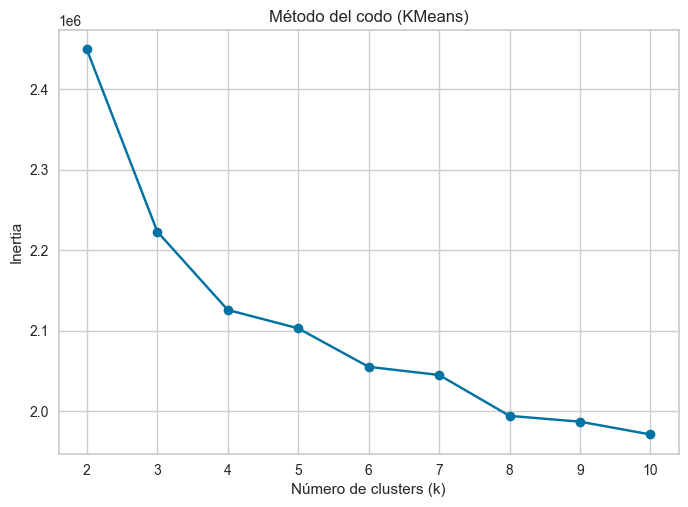

In [14]:
inertia = []
K = range(2, 11)  # probar de 2 a 10 clusters

for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

plt.plot(K, inertia, 'o-')
plt.xlabel("Número de clusters (k)")
plt.ylabel("Inertia")
plt.title("Método del codo (KMeans)")
plt.show()


Más correlacionadas con Binary_Trust + 30% usadas

In [15]:
selected_features = [
    'ch9-LowGamma-Std', 'ch9-LowGamma-PeakToPeak', 'ch8-LowGamma-Std',  
    'ch9-LowGamma-DE', 'ch8-LowGamma-PeakToPeak', 'ch14-LowGamma-PeakToPeak',
    'ch8-LowGamma-HjAct', 'ch9-LowGamma-HjAct', 'ch14-LowGamma-Std', 'ch14-LowGamma-HjAct'
]

In [16]:
all_features = features30["feature"].tolist()
print(f"Se van a usar {len(all_features)} features")


Se van a usar 376 features


comparación resultados con binary trust

In [17]:
# Rango de k a probar
k_values = range(2, 7) 

# Subconjuntos de features a probar
feature_sets = {
    "correlacionadas": selected_features,
    "top30": all_features
}

results = []

for name, features in feature_sets.items():
    X_sub = df_clustering[features].copy()
    
    # Escalamos si no está escalado
    from sklearn.preprocessing import StandardScaler
    X_sub_scaled = StandardScaler().fit_transform(X_sub)
    
    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels_kmeans = kmeans.fit_predict(X_sub_scaled)
        
        # Guardamos clusters en df (opcional)
        df_clustering[f"Cluster_KMeans_{name}_{k}"] = labels_kmeans
        
        # Comparación solo en filas con Binary_Trust
        mask = ~y.isna()
        ari = adjusted_rand_score(y[mask], labels_kmeans[mask])
        ami = adjusted_mutual_info_score(y[mask], labels_kmeans[mask])
        
        crosstab = pd.crosstab(y[mask], labels_kmeans[mask])
        
        print(f"\n--- {name} | k = {k} ---")
        print(f"ARI: {ari:.4f}, AMI: {ami:.4f}")
        print("Tabla de contingencia:")
        print(crosstab)
        
        results.append({
            'feature_set': name,
            'k': k,
            'ARI': ari,
            'AMI': ami,
            'crosstab': crosstab
        })

# Resumen rápido de métricas
summary_df = pd.DataFrame([{'feature_set': r['feature_set'], 'k': r['k'], 'ARI': r['ARI'], 'AMI': r['AMI']} for r in results])
print("\nResumen comparativo:")
print(summary_df)



--- correlacionadas | k = 2 ---
ARI: 0.0124, AMI: 0.0375
Tabla de contingencia:
col_0           0    1
Binary_Trust          
high_trust    848  152
low_trust     960   40

--- correlacionadas | k = 3 ---
ARI: 0.0183, AMI: 0.0421
Tabla de contingencia:
col_0           0   1    2
Binary_Trust              
high_trust    154  82  764
low_trust      65  14  921

--- correlacionadas | k = 4 ---
ARI: 0.0172, AMI: 0.0294
Tabla de contingencia:
col_0           0   1    2    3
Binary_Trust                   
high_trust    479  33  352  136
low_trust     441   5  510   44

--- correlacionadas | k = 5 ---
ARI: 0.0119, AMI: 0.0284
Tabla de contingencia:
col_0           0   1    2    3    4
Binary_Trust                        
high_trust    564  27  168  106  135
low_trust     665   5  231   26   73

--- correlacionadas | k = 6 ---
ARI: 0.0176, AMI: 0.0288
Tabla de contingencia:
col_0           0   1    2   3    4    5
Binary_Trust                            
high_trust    333  27   90  96  111  

Comparación de KMeans con Trust (1-5)

In [18]:
# Rango de k a probar
k_values = range(2, 7) 

# Subconjuntos de features a probar
feature_sets = {
    "correlacionadas": selected_features,
    "top30": all_features
}

results_trust_KMeans = []

for name, features in feature_sets.items():
    X_sub = df_clustering[features].copy()
    
    # Escalamos las features
    X_sub_scaled = StandardScaler().fit_transform(X_sub)
    
    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels_kmeans = kmeans.fit_predict(X_sub_scaled)
        
        # Guardamos clusters en df (opcional)
        df_clustering[f"Cluster_KMeans_{name}_{k}"] = labels_kmeans
        
        # Comparación con Trust (1-5)
        mask = ~df_clustering["Trust"].isna()  # solo filas donde Trust no es NaN
        ari = adjusted_rand_score(df_clustering["Trust"][mask], labels_kmeans[mask])
        ami = adjusted_mutual_info_score(df_clustering["Trust"][mask], labels_kmeans[mask])
        
        crosstab = pd.crosstab(df_clustering["Trust"][mask], labels_kmeans[mask])
        
        print(f"\n--- {name} | k = {k} ---")
        print(f"ARI: {ari:.4f}, AMI: {ami:.4f}")
        print("Tabla de contingencia:")
        print(crosstab)
        
        results_trust_KMeans.append({
            'feature_set': name,
            'k': k,
            'ARI': ari,
            'AMI': ami,
            'crosstab': crosstab
        })

# Resumen rápido de métricas
summary_trust_KMeans = pd.DataFrame([{'feature_set': r['feature_set'], 'k': r['k'], 'ARI': r['ARI'], 'AMI': r['AMI']} for r in results_trust_KMeans])
print("\nResumen comparativo con Trust:")
print(summary_trust_KMeans)



--- correlacionadas | k = 2 ---
ARI: 0.0521, AMI: 0.0478
Tabla de contingencia:
col_0    0   1
Trust         
1.0    960  40
2.0    225  75
3.0    473  77
4.0    150   0

--- correlacionadas | k = 3 ---
ARI: 0.0723, AMI: 0.0557
Tabla de contingencia:
col_0   0   1    2
Trust             
1.0    65  14  921
2.0    74  35  191
3.0    78  47  425
4.0     2   0  148

--- correlacionadas | k = 4 ---
ARI: 0.0456, AMI: 0.0536
Tabla de contingencia:
col_0    0   1    2   3
Trust                  
1.0    441   5  510  44
2.0    158  10   60  72
3.0    272  23  191  64
4.0     49   0  101   0

--- correlacionadas | k = 5 ---
ARI: 0.0471, AMI: 0.0457
Tabla de contingencia:
col_0    0   1    2   3   4
Trust                      
1.0    665   5  231  26  73
2.0    140   8   37  57  58
3.0    314  19   93  49  75
4.0    110   0   38   0   2

--- correlacionadas | k = 6 ---
ARI: 0.0536, AMI: 0.0521
Tabla de contingencia:
col_0    0   1    2   3   4    5
Trust                           
1.0    298   

 Mejor configuración encontrada:
correlacionadas | k = 3 | ARI = 0.07226318027880178

Media de features por cluster:
              ch9-LowGamma-Std  ch9-LowGamma-PeakToPeak  ch8-LowGamma-Std  \
best_cluster                                                                
0                     4.284959                23.180320          4.579887   
1                     7.849990                44.554270          6.674165   
2                     1.574962                 7.173327          2.237703   

              ch9-LowGamma-DE  ch8-LowGamma-PeakToPeak  \
best_cluster                                             
0                    2.775803                24.356130   
1                    3.391688                35.141871   
2                    1.801725                10.185167   

              ch14-LowGamma-PeakToPeak  ch8-LowGamma-HjAct  \
best_cluster                                                 
0                            17.176708           22.326077   
1                   

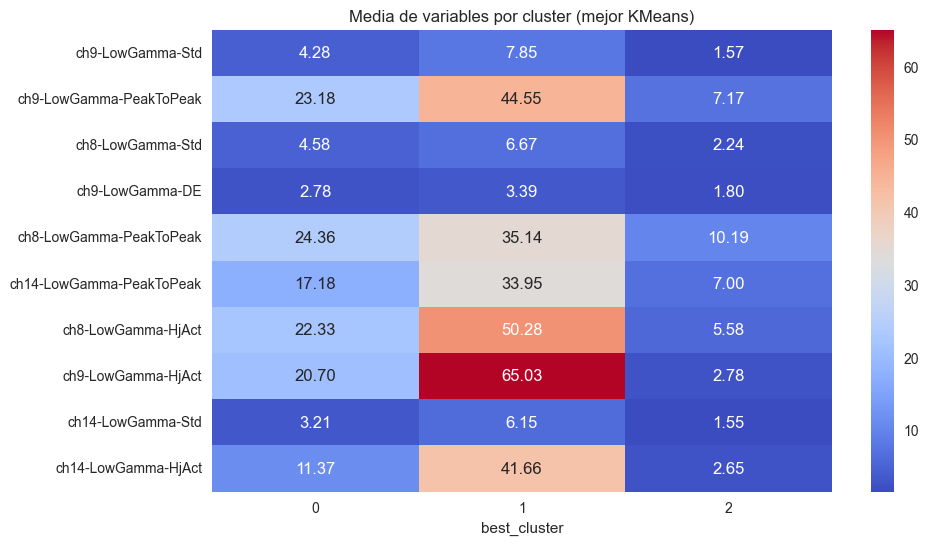


Variables más discriminativas entre clusters:
                    feature      F_value        p_value
0          ch9-LowGamma-Std  4062.701779   0.000000e+00
1   ch9-LowGamma-PeakToPeak  3926.590679   0.000000e+00
7        ch9-LowGamma-HjAct  3118.938736   0.000000e+00
8         ch14-LowGamma-Std  2637.934513   0.000000e+00
5  ch14-LowGamma-PeakToPeak  2637.479725   0.000000e+00
9       ch14-LowGamma-HjAct  1700.136784   0.000000e+00
2          ch8-LowGamma-Std  1682.071632   0.000000e+00
4   ch8-LowGamma-PeakToPeak  1579.818202   0.000000e+00
3           ch9-LowGamma-DE  1091.993135   0.000000e+00
6        ch8-LowGamma-HjAct  1040.967830  2.964394e-323


In [19]:


# === Encontrar la mejor configuración de KMeans según ARI ===
best_run = max(results_trust_KMeans, key=lambda r: r['ARI'])
print(" Mejor configuración encontrada:")
print(best_run['feature_set'], "| k =", best_run['k'], "| ARI =", best_run['ARI'])

# Extraer clusters de la mejor configuración
best_features = feature_sets[best_run['feature_set']]
X_best = df_clustering[best_features].copy()
X_best_scaled = StandardScaler().fit_transform(X_best)

kmeans_best = KMeans(n_clusters=best_run['k'], random_state=42)
df_clustering['best_cluster'] = kmeans_best.fit_predict(X_best_scaled)

# === 1. Media por cluster de cada variable ===
cluster_means = df_clustering.groupby('best_cluster')[best_features].mean()
print("\nMedia de features por cluster:")
print(cluster_means)

# === 2. Heatmap de diferencias por cluster ===
plt.figure(figsize=(10,6))
sns.heatmap(cluster_means.T, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Media de variables por cluster (mejor KMeans)")
plt.show()

# === 3. ANOVA F-score para ver qué variable discrimina más ===
from sklearn.feature_selection import f_classif

f_values, p_values = f_classif(X_best_scaled, df_clustering['best_cluster'])
feature_importance = pd.DataFrame({
    'feature': best_features,
    'F_value': f_values,
    'p_value': p_values
}).sort_values(by="F_value", ascending=False)

print("\nVariables más discriminativas entre clusters:")
print(feature_importance)


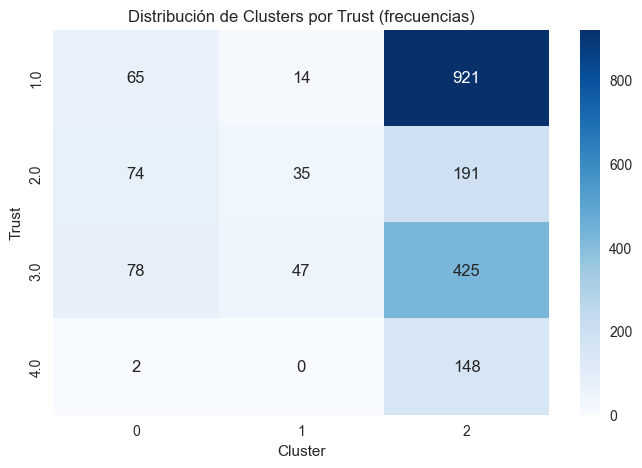

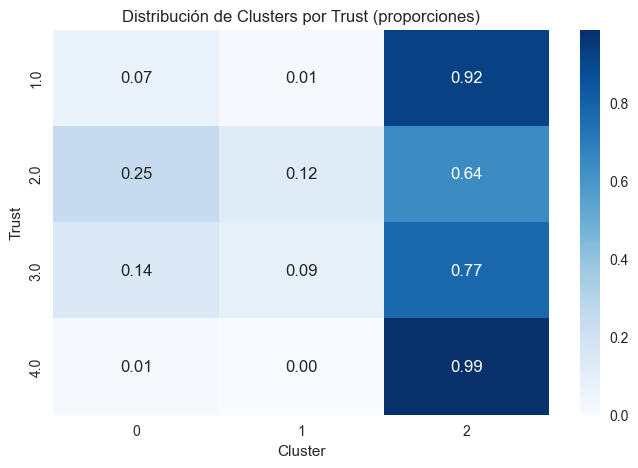

In [20]:
# Tabla de contingencia Trust vs Clusters (frecuencias absolutas)
crosstab_abs = pd.crosstab(df_clustering["Trust"], df_clustering["best_cluster"])

# Tabla normalizada por fila (proporción dentro de cada nivel de Trust)
crosstab_prop = pd.crosstab(df_clustering["Trust"], 
                            df_clustering["best_cluster"], 
                            normalize="index")

# Heatmap de frecuencias absolutas
plt.figure(figsize=(8,5))
sns.heatmap(crosstab_abs, annot=True, fmt="d", cmap="Blues")
plt.title("Distribución de Clusters por Trust (frecuencias)")
plt.ylabel("Trust")
plt.xlabel("Cluster")
plt.show()

# Heatmap de proporciones
plt.figure(figsize=(8,5))
sns.heatmap(crosstab_prop, annot=True, fmt=".2f", cmap="Blues")
plt.title("Distribución de Clusters por Trust (proporciones)")
plt.ylabel("Trust")
plt.xlabel("Cluster")
plt.show()


### DBSCAN Clustering mas de 2 clusters - Binary_Trust

In [21]:
# Parámetros a probar
eps_values = [0.5, 1.0, 1.5, 2.0] 
min_samples_values = [5, 10, 20] 

feature_sets = {
    "correlacionadas": selected_features,
    "top30": all_features
}

results_dbscan = []

for name, features in feature_sets.items():
    X_sub = df_clustering[features].copy()
    X_sub_scaled = StandardScaler().fit_transform(X_sub)
    
    for eps in eps_values:
        for min_samples in min_samples_values:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            labels = dbscan.fit_predict(X_sub_scaled)
            
            mask = ~y.isna()
            ari = adjusted_rand_score(y[mask], labels[mask])
            ami = adjusted_mutual_info_score(y[mask], labels[mask])
            
            crosstab = pd.crosstab(y[mask], labels[mask])
            
            print(f"\n--- {name} | eps={eps} | min_samples={min_samples} ---")
            print(f"ARI: {ari:.4f}, AMI: {ami:.4f}")
            print("Tabla de contingencia:")
            print(crosstab)
            
            results_dbscan.append({
                'feature_set': name,
                'eps': eps,
                'min_samples': min_samples,
                'ARI': ari,
                'AMI': ami,
                'crosstab': crosstab
            })

# Resumen rápido de métricas
summary_dbscan = pd.DataFrame([{
    'feature_set': r['feature_set'], 
    'eps': r['eps'], 
    'min_samples': r['min_samples'], 
    'ARI': r['ARI'], 
    'AMI': r['AMI']
} for r in results_dbscan])

print("\nResumen comparativo DBSCAN:")
print(summary_dbscan)



--- correlacionadas | eps=0.5 | min_samples=5 ---
ARI: 0.0277, AMI: 0.0349
Tabla de contingencia:
col_0          -1    0   1
Binary_Trust              
high_trust    293  703   4
low_trust     127  872   1

--- correlacionadas | eps=0.5 | min_samples=10 ---
ARI: 0.0275, AMI: 0.0302
Tabla de contingencia:
col_0          -1    0
Binary_Trust          
high_trust    329  671
low_trust     162  838

--- correlacionadas | eps=0.5 | min_samples=20 ---
ARI: 0.0275, AMI: 0.0263
Tabla de contingencia:
col_0          -1    0
Binary_Trust          
high_trust    370  630
low_trust     203  797

--- correlacionadas | eps=1.0 | min_samples=5 ---
ARI: 0.0143, AMI: 0.0389
Tabla de contingencia:
col_0          -1    0   1   2   3
Binary_Trust                      
high_trust    154  824   5   7  10
low_trust      42  952   0   2   4

--- correlacionadas | eps=1.0 | min_samples=10 ---
ARI: 0.0164, AMI: 0.0387
Tabla de contingencia:
col_0          -1    0
Binary_Trust          
high_trust    184  816
l

### DBSCAN Clustering mas de 2 clusters - Trust (1-5)

In [22]:
# Subconjuntos de features a probar
feature_sets = {
    "correlacionadas": selected_features,
    "top30": all_features
}

# Parámetros DBSCAN
eps_values = [0.5, 1.0, 1.5, 2.0]
min_samples_values = [5, 10, 20]

results_trust_dbscan = []

for name, features in feature_sets.items():
    X_sub = df_clustering[features].copy()
    X_sub_scaled = StandardScaler().fit_transform(X_sub)
    
    for eps in eps_values:
        for min_samples in min_samples_values:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            labels = dbscan.fit_predict(X_sub_scaled)
            
            # Comparación con Trust
            mask = ~df_clustering["Trust"].isna()
            ari = adjusted_rand_score(df_clustering["Trust"][mask], labels[mask])
            ami = adjusted_mutual_info_score(df_clustering["Trust"][mask], labels[mask])
            
            crosstab = pd.crosstab(df_clustering["Trust"][mask], labels[mask])
            
            print(f"\n--- {name} | eps={eps} | min_samples={min_samples} ---")
            print(f"ARI: {ari:.4f}, AMI: {ami:.4f}")
            print("Tabla de contingencia:")
            print(crosstab)
            
            results_trust_dbscan.append({
                'feature_set': name,
                'eps': eps,
                'min_samples': min_samples,
                'ARI': ari,
                'AMI': ami,
                'crosstab': crosstab,
                'labels': labels,
                'features': features
            })

# Resumen rápido
summary_trust_dbscan = pd.DataFrame([{
    'feature_set': r['feature_set'],
    'eps': r['eps'],
    'min_samples': r['min_samples'],
    'ARI': r['ARI'],
    'AMI': r['AMI']
} for r in results_trust_dbscan])

print("\nResumen comparativo DBSCAN con Trust:")
print(summary_trust_dbscan)



--- correlacionadas | eps=0.5 | min_samples=5 ---
ARI: 0.0707, AMI: 0.0528
Tabla de contingencia:
col_0   -1    0   1
Trust              
1.0    127  872   1
2.0    124  173   3
3.0    165  384   1
4.0      4  146   0

--- correlacionadas | eps=0.5 | min_samples=10 ---
ARI: 0.0660, AMI: 0.0518
Tabla de contingencia:
col_0   -1    0
Trust          
1.0    162  838
2.0    139  161
3.0    185  365
4.0      5  145

--- correlacionadas | eps=0.5 | min_samples=20 ---
ARI: 0.0608, AMI: 0.0474
Tabla de contingencia:
col_0   -1    0
Trust          
1.0    203  797
2.0    151  149
3.0    210  340
4.0      9  141

--- correlacionadas | eps=1.0 | min_samples=5 ---
ARI: 0.0594, AMI: 0.0495
Tabla de contingencia:
col_0  -1    0   1   2   3
Trust                     
1.0    42  952   0   2   4
2.0    73  215   3   4   5
3.0    81  459   2   3   5
4.0     0  150   0   0   0

--- correlacionadas | eps=1.0 | min_samples=10 ---
ARI: 0.0591, AMI: 0.0525
Tabla de contingencia:
col_0  -1    0
Trust        


Mejor resultado DBSCAN:
correlacionadas 0.5 5
ARI: 0.07071212492663133 AMI: 0.052751908519386395
col_0   -1    0   1
Trust              
1.0    127  872   1
2.0    124  173   3
3.0    165  384   1
4.0      4  146   0


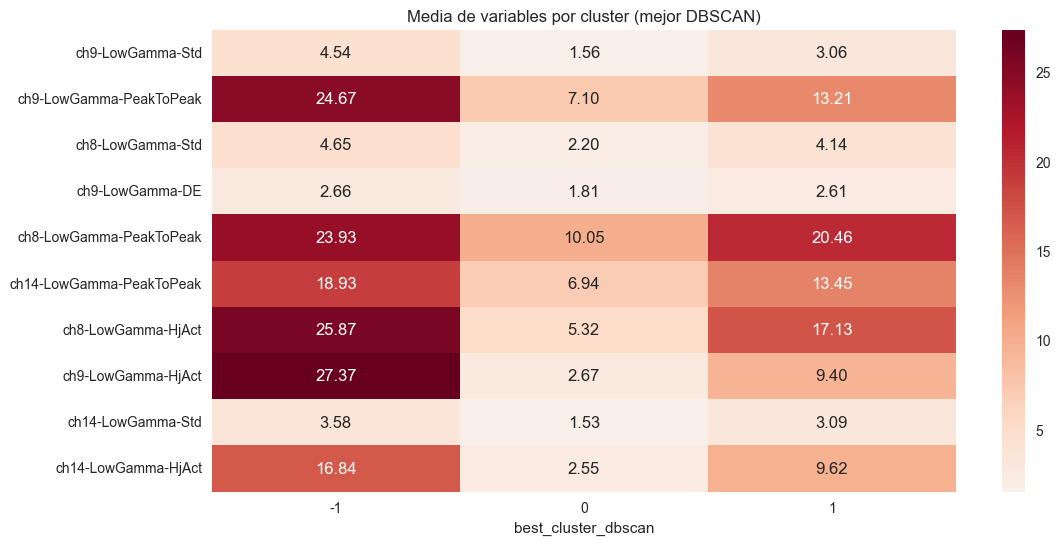

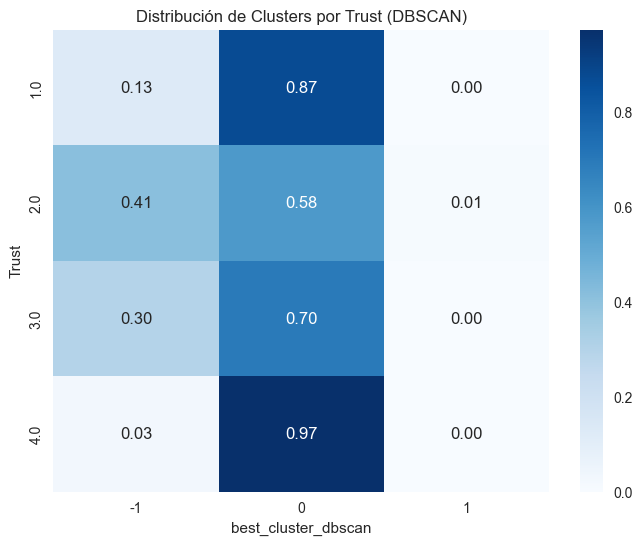

In [23]:

# Seleccionar el mejor resultado (por ARI)

best_result = max(results_trust_dbscan, key=lambda r: r['ARI'])
print("\nMejor resultado DBSCAN:")
print(best_result['feature_set'], best_result['eps'], best_result['min_samples'])
print("ARI:", best_result['ARI'], "AMI:", best_result['AMI'])
print(best_result['crosstab'])

df_clustering['best_cluster_dbscan'] = best_result['labels']


# Heatmap: medias de variables por cluster

cluster_means = df_clustering.groupby('best_cluster_dbscan')[best_result['features']].mean()

plt.figure(figsize=(12,6))
sns.heatmap(cluster_means.T, cmap="RdBu_r", center=0, annot=True, fmt=".2f")
plt.title("Media de variables por cluster (mejor DBSCAN)")
plt.show()


# Heatmap: distribución de Trust por cluster

trust_cluster_dist = pd.crosstab(df_clustering["Trust"], df_clustering["best_cluster_dbscan"], normalize='index')

plt.figure(figsize=(8,6))
sns.heatmap(trust_cluster_dist, cmap="Blues", annot=True, fmt=".2f")
plt.title("Distribución de Clusters por Trust (DBSCAN)")
plt.show()

### Agglomerative Clustering mas de 2 clusters - Binary_Trust

In [24]:
# Rango de n_clusters a probar
cluster_values = range(2, 7)  # 2,3,4,5,6

feature_sets = {
    "correlacionadas": selected_features,
    "top30": all_features
}

results_agglo = []

for name, features in feature_sets.items():
    X_sub = df_clustering[features].copy()
    X_sub_scaled = StandardScaler().fit_transform(X_sub)
    
    for n_clusters in cluster_values:
        agglo = AgglomerativeClustering(n_clusters=n_clusters)
        labels = agglo.fit_predict(X_sub_scaled)
        
        mask = ~y.isna()
        ari = adjusted_rand_score(y[mask], labels[mask])
        ami = adjusted_mutual_info_score(y[mask], labels[mask])
        
        crosstab = pd.crosstab(y[mask], labels[mask])
        
        print(f"\n--- {name} | n_clusters={n_clusters} ---")
        print(f"ARI: {ari:.4f}, AMI: {ami:.4f}")
        print("Tabla de contingencia:")
        print(crosstab)
        
        results_agglo.append({
            'feature_set': name,
            'n_clusters': n_clusters,
            'ARI': ari,
            'AMI': ami,
            'crosstab': crosstab
        })

# Resumen rápido de métricas
summary_agglo = pd.DataFrame([{
    'feature_set': r['feature_set'], 
    'n_clusters': r['n_clusters'], 
    'ARI': r['ARI'], 
    'AMI': r['AMI']
} for r in results_agglo])

print("\nResumen comparativo Agglomerative:")
print(summary_agglo)



--- correlacionadas | n_clusters=2 ---
ARI: 0.0228, AMI: 0.0386
Tabla de contingencia:
col_0           0    1
Binary_Trust          
high_trust    237  763
low_trust      85  915

--- correlacionadas | n_clusters=3 ---
ARI: 0.0192, AMI: 0.0390
Tabla de contingencia:
col_0           0    1   2
Binary_Trust              
high_trust    203  763  34
low_trust      81  915   4

--- correlacionadas | n_clusters=4 ---
ARI: 0.0157, AMI: 0.0372
Tabla de contingencia:
col_0           0    1   2   3
Binary_Trust                  
high_trust    763  109  34  94
low_trust     915   33   4  48

--- correlacionadas | n_clusters=5 ---
ARI: 0.0096, AMI: 0.0289
Tabla de contingencia:
col_0          0    1    2   3    4
Binary_Trust                       
high_trust    34  109  606  94  157
low_trust      4   33  681  48  234

--- correlacionadas | n_clusters=6 ---
ARI: 0.0096, AMI: 0.0289
Tabla de contingencia:
col_0          0    1    2   3    4
Binary_Trust                       
high_trust    34  10

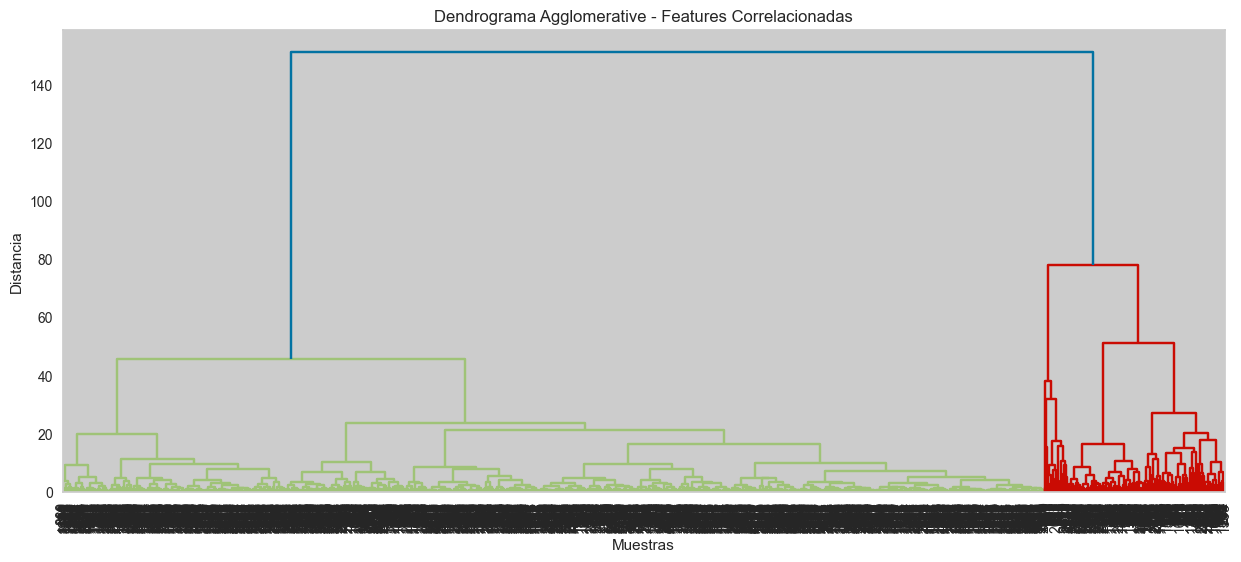

In [25]:
# Elegimos el set de features que quieras, por ejemplo las correlacionadas
X_sub = df_clustering[selected_features].copy()
X_scaled = StandardScaler().fit_transform(X_sub)

# Calculamos la matriz de linkage
Z = linkage(X_scaled, method='ward')  

# Dibujamos el dendrograma
plt.figure(figsize=(15, 6))
dendrogram(
    Z,
    truncate_mode='level',  
    p=30, 
    leaf_rotation=90.,
    leaf_font_size=10.
)
plt.title("Dendrograma Agglomerative - Features Correlacionadas")
plt.xlabel("Muestras")
plt.ylabel("Distancia")
plt.show()


### Agglomerative Clustering mas de 2 clusters - Trust (1-5)

In [26]:
# Rango de n_clusters a probar
cluster_values = range(2, 7)  # 2,3,4,5,6

feature_sets = {
    "correlacionadas": selected_features,
    "top30": all_features
}

results_trust_agglo = []

for name, features in feature_sets.items():
    X_sub = df_clustering[features].copy()
    X_sub_scaled = StandardScaler().fit_transform(X_sub)
    
    for n_clusters in cluster_values:
        agglo = AgglomerativeClustering(n_clusters=n_clusters)
        labels = agglo.fit_predict(X_sub_scaled)
        
        # Comparación con Trust (1-5)
        mask = ~df_clustering["Trust"].isna()  
        ari = adjusted_rand_score(df_clustering["Trust"][mask], labels[mask])
        ami = adjusted_mutual_info_score(df_clustering["Trust"][mask], labels[mask])
        
        crosstab = pd.crosstab(df_clustering["Trust"][mask], labels[mask])
        
        print(f"\n--- {name} | n_clusters={n_clusters} ---")
        print(f"ARI: {ari:.4f}, AMI: {ami:.4f}")
        print("Tabla de contingencia:")
        print(crosstab)
        
        results_trust_agglo.append({
            'feature_set': name,
            'n_clusters': n_clusters,
            'ARI': ari,
            'AMI': ami,
            'crosstab': crosstab,
            'labels': labels,
            'features': features
        })

# Resumen rápido
summary_trust_agglo = pd.DataFrame([{
    'feature_set': r['feature_set'], 
    'n_clusters': r['n_clusters'], 
    'ARI': r['ARI'], 
    'AMI': r['AMI']
} for r in results_trust_agglo])

print("\nResumen comparativo Agglomerative con Trust:")
print(summary_trust_agglo)



--- correlacionadas | n_clusters=2 ---
ARI: 0.0701, AMI: 0.0560
Tabla de contingencia:
col_0    0    1
Trust          
1.0     85  915
2.0    114  186
3.0    121  429
4.0      2  148

--- correlacionadas | n_clusters=3 ---
ARI: 0.0705, AMI: 0.0561
Tabla de contingencia:
col_0    0    1   2
Trust              
1.0     81  915   4
2.0    102  186  12
3.0     99  429  22
4.0      2  148   0

--- correlacionadas | n_clusters=4 ---
ARI: 0.0718, AMI: 0.0543
Tabla de contingencia:
col_0    0   1   2   3
Trust                 
1.0    915  33   4  48
2.0    186  58  12  44
3.0    429  51  22  48
4.0    148   0   0   2

--- correlacionadas | n_clusters=5 ---
ARI: 0.0443, AMI: 0.0459
Tabla de contingencia:
col_0   0   1    2   3    4
Trust                      
1.0     4  33  681  48  234
2.0    12  58  151  44   35
3.0    22  51  351  48   78
4.0     0   0  104   2   44

--- correlacionadas | n_clusters=6 ---
ARI: 0.0443, AMI: 0.0459
Tabla de contingencia:
col_0   0   1    2   3    4
Trust     

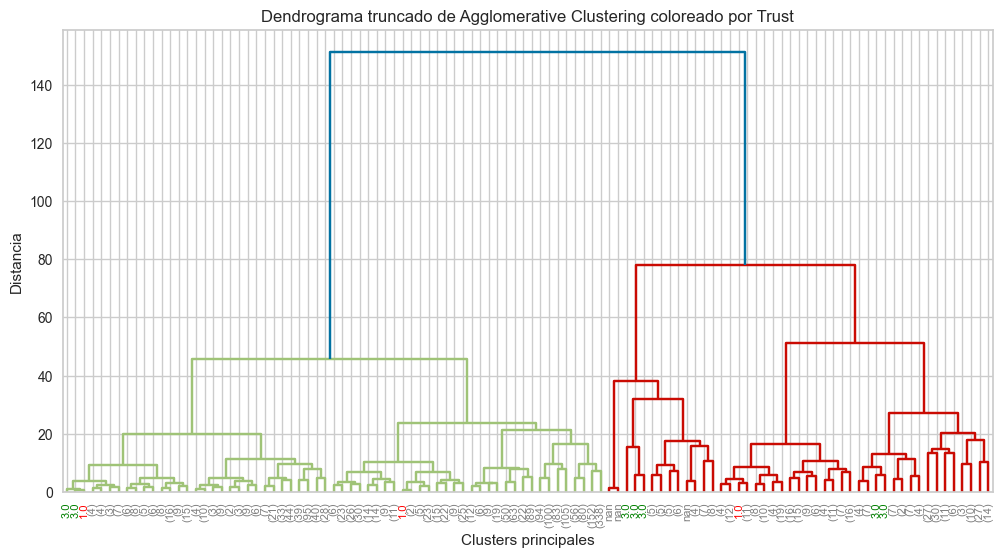

In [27]:
# Seleccionamos subset (ejemplo: variables correlacionadas)
X_sub = df_clustering[selected_features].copy()
X_sub_scaled = StandardScaler().fit_transform(X_sub)

# Jerarquía
Z = linkage(X_sub_scaled, method='ward')

# Valores de Trust como etiquetas
trust_values = df_clustering["Trust"].astype(str).tolist()
trust_colors = {
    "1.0": "red",
    "2.0": "orange",
    "3.0": "green",
    "4.0": "blue"
}

# Dendrograma truncado
plt.figure(figsize=(12,6))
dendro = dendrogram(
    Z,
    truncate_mode="level", 
    p=6,                    
    labels=trust_values,
    leaf_rotation=90,
    leaf_font_size=8,
    show_leaf_counts=True
)

# Colorear etiquetas por Trust
ax = plt.gca()
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    lbl.set_color(trust_colors.get(lbl.get_text(), "gray"))

plt.title("Dendrograma truncado de Agglomerative Clustering coloreado por Trust")
plt.xlabel("Clusters principales")
plt.ylabel("Distancia")
plt.show()



Mejor resultado Agglomerative:
correlacionadas 4
ARI: 0.07183569707077582 AMI: 0.054331660027314994
col_0    0   1   2   3
Trust                 
1.0    915  33   4  48
2.0    186  58  12  44
3.0    429  51  22  48
4.0    148   0   0   2


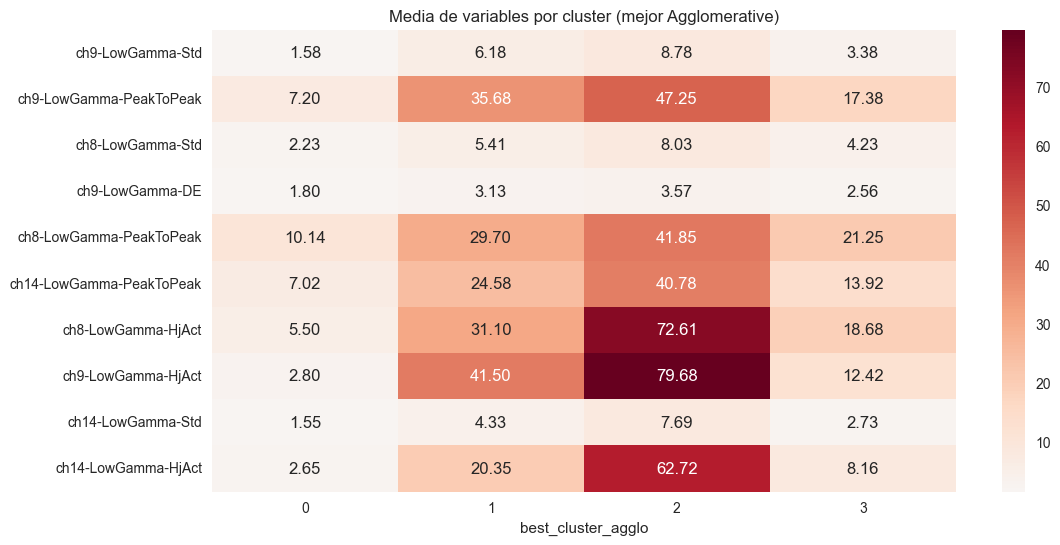

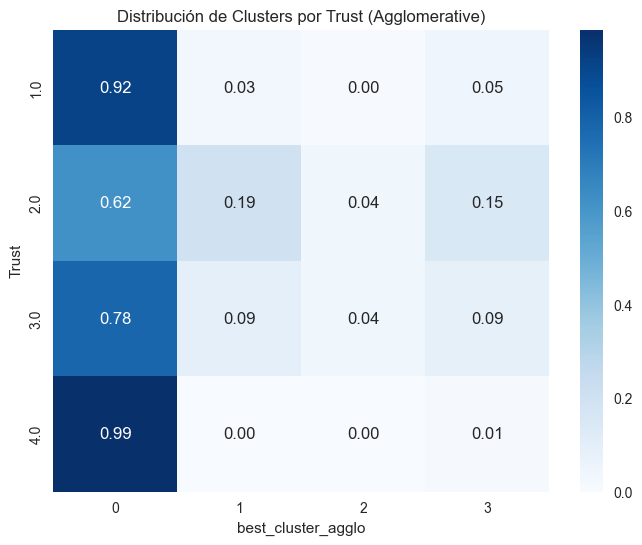

In [28]:

# Seleccionar el mejor resultado (por ARI)

best_result_agglo = max(results_trust_agglo, key=lambda r: r['ARI'])
print("\nMejor resultado Agglomerative:")
print(best_result_agglo['feature_set'], best_result_agglo['n_clusters'])
print("ARI:", best_result_agglo['ARI'], "AMI:", best_result_agglo['AMI'])
print(best_result_agglo['crosstab'])

# Añadir etiquetas al dataframe
df_clustering['best_cluster_agglo'] = best_result_agglo['labels']


# Heatmap: medias de variables por cluster

cluster_means = df_clustering.groupby('best_cluster_agglo')[best_result_agglo['features']].mean()

plt.figure(figsize=(12,6))
sns.heatmap(cluster_means.T, cmap="RdBu_r", center=0, annot=True, fmt=".2f")
plt.title("Media de variables por cluster (mejor Agglomerative)")
plt.show()


# Heatmap: distribución de Trust por cluster

trust_cluster_dist = pd.crosstab(df_clustering["Trust"], df_clustering["best_cluster_agglo"], normalize='index')

plt.figure(figsize=(8,6))
sns.heatmap(trust_cluster_dist, cmap="Blues", annot=True, fmt=".2f")
plt.title("Distribución de Clusters por Trust (Agglomerative)")
plt.show()


### Otros métodos de clustering - Binary_Trust

### OPTICS - Binary_Trust

In [29]:
results_optics = []

feature_sets = {
    "correlacionadas": selected_features,
    "top30": all_features
}

# OPTICS
for name, features in feature_sets.items():
    X_sub = df_clustering[features].copy()
    X_sub_scaled = StandardScaler().fit_transform(X_sub)

    optics = OPTICS(min_samples=10, xi=0.05, min_cluster_size=0.05)
    labels = optics.fit_predict(X_sub_scaled)

    mask = ~y.isna()
    ari = adjusted_rand_score(y[mask], labels[mask])
    ami = adjusted_mutual_info_score(y[mask], labels[mask])

    crosstab = pd.crosstab(y[mask], labels[mask])

    print(f"\n--- {name} | OPTICS ---")
    print(f"ARI: {ari:.4f}, AMI: {ami:.4f}")
    print("Tabla de contingencia:")
    print(crosstab)

    results_optics.append({
        'feature_set': name,
        'method': "OPTICS",
        'ARI': ari,
        'AMI': ami,
        'crosstab': crosstab
    })

# Resumen final
summary_optics = pd.DataFrame([{
    'feature_set': r['feature_set'], 
    'method': r['method'], 
    'ARI': r['ARI'], 
    'AMI': r['AMI']
} for r in results_optics])

print("\nResumen comparativo OPTICS:")
print(summary_optics)


--- correlacionadas | OPTICS ---
ARI: 0.0000, AMI: 0.0000
Tabla de contingencia:
col_0            0
Binary_Trust      
high_trust    1000
low_trust     1000

--- top30 | OPTICS ---
ARI: 0.0000, AMI: 0.0000
Tabla de contingencia:
col_0            0
Binary_Trust      
high_trust    1000
low_trust     1000

Resumen comparativo OPTICS:
       feature_set  method  ARI  AMI
0  correlacionadas  OPTICS  0.0  0.0
1            top30  OPTICS  0.0  0.0


### OPTICS Trust (1-5)

In [32]:
results_optics_trust = []

feature_sets = {
    "correlacionadas": selected_features,
    "top30": all_features
}

# OPTICS
for name, features in feature_sets.items():
    X_sub = df_clustering[features].copy()
    X_sub_scaled = StandardScaler().fit_transform(X_sub)

    optics = OPTICS(min_samples=10, xi=0.05, min_cluster_size=0.05)
    labels = optics.fit_predict(X_sub_scaled)

    # Comparación con Trust (1-5)
    mask = ~df_clustering["Trust"].isna()
    ari = adjusted_rand_score(df_clustering["Trust"][mask], labels[mask])
    ami = adjusted_mutual_info_score(df_clustering["Trust"][mask], labels[mask])

    crosstab = pd.crosstab(df_clustering["Trust"][mask], labels[mask])

    print(f"\n--- {name} | OPTICS ---")
    print(f"ARI: {ari:.4f}, AMI: {ami:.4f}")
    print("Tabla de contingencia:")
    print(crosstab)

    results_optics_trust.append({
        'feature_set': name,
        'method': "OPTICS",
        'ARI': ari,
        'AMI': ami,
        'crosstab': crosstab
    })

# Resumen final
summary_optics_trust = pd.DataFrame([{
    'feature_set': r['feature_set'], 
    'method': r['method'], 
    'ARI': r['ARI'], 
    'AMI': r['AMI']
} for r in results_optics_trust])

print("\nResumen comparativo OPTICS con Trust:")
print(summary_optics_trust)



--- correlacionadas | OPTICS ---
ARI: 0.0000, AMI: 0.0000
Tabla de contingencia:
col_0     0
Trust      
1.0    1000
2.0     300
3.0     550
4.0     150

--- top30 | OPTICS ---
ARI: 0.0000, AMI: 0.0000
Tabla de contingencia:
col_0     0
Trust      
1.0    1000
2.0     300
3.0     550
4.0     150

Resumen comparativo OPTICS con Trust:
       feature_set  method  ARI  AMI
0  correlacionadas  OPTICS  0.0  0.0
1            top30  OPTICS  0.0  0.0


### MeanShift - Binary_Trust

In [33]:
results_MeanShift = []

feature_sets = {
    "correlacionadas": selected_features,
    "top30": all_features
}

# MeanShift
for name, features in feature_sets.items():
    X_sub = df_clustering[features].copy()
    X_sub_scaled = StandardScaler().fit_transform(X_sub)

    ms = MeanShift()
    labels = ms.fit_predict(X_sub_scaled)

    mask = ~y.isna()
    ari = adjusted_rand_score(y[mask], labels[mask])
    ami = adjusted_mutual_info_score(y[mask], labels[mask])

    crosstab = pd.crosstab(y[mask], labels[mask])

    print(f"\n--- {name} | MeanShift ---")
    print(f"ARI: {ari:.4f}, AMI: {ami:.4f}")
    print("Tabla de contingencia:")
    print(crosstab)

    results_MeanShift.append({
        'feature_set': name,
        'method': "MeanShift",
        'ARI': ari,
        'AMI': ami,
        'crosstab': crosstab
    })

# Resumen final
summary_MeanShift = pd.DataFrame([{
    'feature_set': r['feature_set'], 
    'method': r['method'], 
    'ARI': r['ARI'], 
    'AMI': r['AMI']
} for r in results_MeanShift])

print("\nResumen comparativo MeanShift:")
print(summary_MeanShift)


--- correlacionadas | MeanShift ---
ARI: 0.0100, AMI: 0.0353
Tabla de contingencia:
col_0          0   1   2   3   4   5   6   7   8   9   ...  35  36  37  38  \
Binary_Trust                                           ...                   
high_trust    810  75  15   8   5   8   7   5   5   9  ...   0   1   2   1   
low_trust     941  21   6   2   2   0   0   0   0   0  ...   1   0   1   0   

col_0         39  40  41  42  44  45  
Binary_Trust                          
high_trust     1   1   1   5   1   1  
low_trust      0   0   0   0   0   0  

[2 rows x 38 columns]

--- top30 | MeanShift ---
ARI: 0.0066, AMI: 0.0098
Tabla de contingencia:
col_0         0    1    3    6    8    10   11   13   14   15   ...  232  233  \
Binary_Trust                                                    ...             
high_trust    795    6    0    1    1    1    1    1    1    1  ...    2    0   
low_trust     911    4    2    0    0    0    0    0    0    0  ...    0    1   

col_0         234  235 

#### MeanShift Trust (1-5)

In [34]:
results_MeanShift_trust = []

feature_sets = {
    "correlacionadas": selected_features,
    "top30": all_features
}

# MeanShift
for name, features in feature_sets.items():
    X_sub = df_clustering[features].copy()
    X_sub_scaled = StandardScaler().fit_transform(X_sub)

    ms = MeanShift()
    labels = ms.fit_predict(X_sub_scaled)

    # Comparación con Trust (1-5)
    mask = ~df_clustering["Trust"].isna()
    ari = adjusted_rand_score(df_clustering["Trust"][mask], labels[mask])
    ami = adjusted_mutual_info_score(df_clustering["Trust"][mask], labels[mask])

    crosstab = pd.crosstab(df_clustering["Trust"][mask], labels[mask])

    print(f"\n--- {name} | MeanShift ---")
    print(f"ARI: {ari:.4f}, AMI: {ami:.4f}")
    print("Tabla de contingencia:")
    print(crosstab)

    results_MeanShift_trust.append({
        'feature_set': name,
        'method': "MeanShift",
        'ARI': ari,
        'AMI': ami,
        'crosstab': crosstab,
        'labels': labels,
        'features': features
    })

# Resumen final
summary_MeanShift_trust = pd.DataFrame([{
    'feature_set': r['feature_set'], 
    'method': r['method'], 
    'ARI': r['ARI'], 
    'AMI': r['AMI']
} for r in results_MeanShift_trust])

print("\nResumen comparativo MeanShift con Trust:")
print(summary_MeanShift_trust)



--- correlacionadas | MeanShift ---
ARI: 0.0604, AMI: 0.0528
Tabla de contingencia:
col_0   0   1   2   3   4   5   6   7   8   9   ...  35  36  37  38  39  40  \
Trust                                           ...                           
1.0    941  21   6   2   2   0   0   0   0   0  ...   1   0   1   0   0   0   
2.0    210  42  10   1   2   5   1   5   0   4  ...   0   0   2   0   0   1   
3.0    450  33   5   7   3   3   6   0   5   5  ...   0   1   0   1   1   0   
4.0    150   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   

col_0  41  42  44  45  
Trust                  
1.0     0   0   0   0  
2.0     0   3   1   0  
3.0     1   2   0   1  
4.0     0   0   0   0  

[4 rows x 38 columns]

--- top30 | MeanShift ---
ARI: 0.0556, AMI: 0.0313
Tabla de contingencia:
col_0  0    1    3    6    8    10   11   13   14   15   ...  232  233  234  \
Trust                                                    ...                  
1.0    911    4    2    0    0    0    0

### Gaussian Mixture - Binary_Trust

In [36]:
results_Gaussian = []

feature_sets = {
    "correlacionadas": selected_features,
    "top30": all_features
}

# Gaussian Mixture (probabilístico)
n_clusters_range = range(2, 7)
for name, features in feature_sets.items():
    X_sub = df_clustering[features].copy()
    X_sub_scaled = StandardScaler().fit_transform(X_sub)

    for n_clusters in n_clusters_range:
        gmm = GaussianMixture(n_components=n_clusters, random_state=42)
        labels = gmm.fit_predict(X_sub_scaled)

        mask = ~y.isna()
        ari = adjusted_rand_score(y[mask], labels[mask])
        ami = adjusted_mutual_info_score(y[mask], labels[mask])

        crosstab = pd.crosstab(y[mask], labels[mask])

        print(f"\n--- {name} | GaussianMixture n_clusters={n_clusters} ---")
        print(f"ARI: {ari:.4f}, AMI: {ami:.4f}")
        print("Tabla de contingencia:")
        print(crosstab)

        results_Gaussian.append({
            'feature_set': name,
            'method': f"GMM_{n_clusters}",
            'ARI': ari,
            'AMI': ami,
            'crosstab': crosstab
        })

# Resumen final
summary_Gaussian = pd.DataFrame([{
    'feature_set': r['feature_set'], 
    'method': r['method'], 
    'ARI': r['ARI'], 
    'AMI': r['AMI']
} for r in results_Gaussian])

print("\nResumen comparativo  GMM:")
print(summary_Gaussian)



--- correlacionadas | GaussianMixture n_clusters=2 ---
ARI: 0.0276, AMI: 0.0364
Tabla de contingencia:
col_0           0    1
Binary_Trust          
high_trust    713  287
low_trust     880  120

--- correlacionadas | GaussianMixture n_clusters=3 ---
ARI: 0.0299, AMI: 0.0354
Tabla de contingencia:
col_0           0    1    2
Binary_Trust               
high_trust    282  192  526
low_trust     219   58  723

--- correlacionadas | GaussianMixture n_clusters=4 ---
ARI: 0.0215, AMI: 0.0278
Tabla de contingencia:
col_0           0    1    2    3
Binary_Trust                    
high_trust    389  182  184  245
low_trust     538   53  225  184

--- correlacionadas | GaussianMixture n_clusters=5 ---
ARI: 0.0191, AMI: 0.0258
Tabla de contingencia:
col_0           0   1    2    3    4
Binary_Trust                        
high_trust    365  21  180  183  251
low_trust     507   4  225   62  202

--- correlacionadas | GaussianMixture n_clusters=6 ---
ARI: 0.0212, AMI: 0.0284
Tabla de contingenc

### Gaussian Mixture - Trust (1-5)

In [37]:
results_Gaussian_trust = []

feature_sets = {
    "correlacionadas": selected_features,
    "top30": all_features
}

# Gaussian Mixture (probabilístico)
n_clusters_range = range(2, 7)
for name, features in feature_sets.items():
    X_sub = df_clustering[features].copy()
    X_sub_scaled = StandardScaler().fit_transform(X_sub)

    for n_clusters in n_clusters_range:
        gmm = GaussianMixture(n_components=n_clusters, random_state=42)
        labels = gmm.fit_predict(X_sub_scaled)

        # Comparación con Trust (1-5)
        mask = ~df_clustering["Trust"].isna()
        ari = adjusted_rand_score(df_clustering["Trust"][mask], labels[mask])
        ami = adjusted_mutual_info_score(df_clustering["Trust"][mask], labels[mask])

        crosstab = pd.crosstab(df_clustering["Trust"][mask], labels[mask])

        print(f"\n--- {name} | GaussianMixture n_clusters={n_clusters} ---")
        print(f"ARI: {ari:.4f}, AMI: {ami:.4f}")
        print("Tabla de contingencia:")
        print(crosstab)

        results_Gaussian_trust.append({
            'feature_set': name,
            'method': f"GMM_{n_clusters}",
            'ARI': ari,
            'AMI': ami,
            'crosstab': crosstab,
            'labels': labels,
            'features': features
        })

# Resumen final
summary_Gaussian_trust = pd.DataFrame([{
    'feature_set': r['feature_set'], 
    'method': r['method'], 
    'ARI': r['ARI'], 
    'AMI': r['AMI']
} for r in results_Gaussian_trust])

print("\nResumen comparativo GMM con Trust:")
print(summary_Gaussian_trust)



--- correlacionadas | GaussianMixture n_clusters=2 ---
ARI: 0.0702, AMI: 0.0545
Tabla de contingencia:
col_0    0    1
Trust          
1.0    880  120
2.0    177  123
3.0    389  161
4.0    147    3

--- correlacionadas | GaussianMixture n_clusters=3 ---
ARI: 0.0783, AMI: 0.0629
Tabla de contingencia:
col_0    0   1    2
Trust              
1.0    219  58  723
2.0     95  94  111
3.0    172  98  280
4.0     15   0  135

--- correlacionadas | GaussianMixture n_clusters=4 ---
ARI: 0.0528, AMI: 0.0487
Tabla de contingencia:
col_0    0   1    2    3
Trust                   
1.0    538  53  225  184
2.0     88  88   44   80
3.0    207  94   96  153
4.0     94   0   44   12

--- correlacionadas | GaussianMixture n_clusters=5 ---
ARI: 0.0487, AMI: 0.0463
Tabla de contingencia:
col_0    0   1    2   3    4
Trust                       
1.0    507   4  225  62  202
2.0     80  11   44  85   80
3.0    194  10   93  98  155
4.0     91   0   43   0   16

--- correlacionadas | GaussianMixture n_clu


Mejor resultado GMM:
correlacionadas GMM_3
ARI: 0.07833833956193607 AMI: 0.06289603936610717
col_0    0   1    2
Trust              
1.0    219  58  723
2.0     95  94  111
3.0    172  98  280
4.0     15   0  135


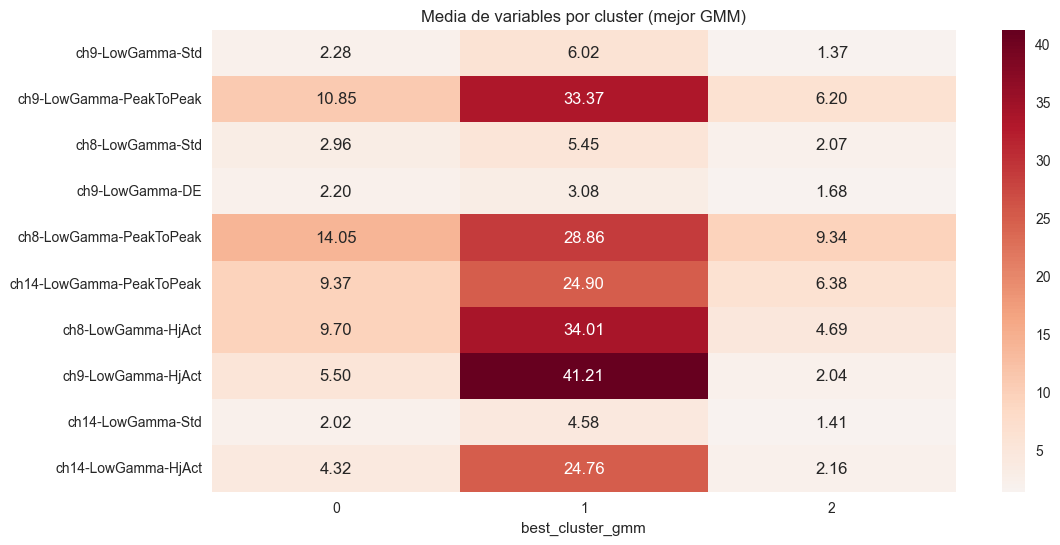

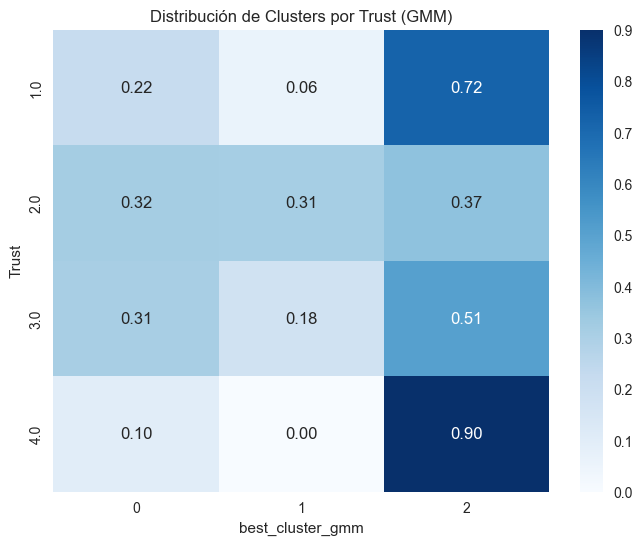

In [38]:

# Seleccionar el mejor resultado (por ARI)

best_result_gmm = max(results_Gaussian_trust, key=lambda r: r['ARI'])
print("\nMejor resultado GMM:")
print(best_result_gmm['feature_set'], best_result_gmm['method'])
print("ARI:", best_result_gmm['ARI'], "AMI:", best_result_gmm['AMI'])
print(best_result_gmm['crosstab'])

# Añadir etiquetas al dataframe
df_clustering['best_cluster_gmm'] = best_result_gmm['labels']


# Heatmap: medias de variables por cluster

cluster_means = df_clustering.groupby('best_cluster_gmm')[best_result_gmm['features']].mean()

plt.figure(figsize=(12,6))
sns.heatmap(cluster_means.T, cmap="RdBu_r", center=0, annot=True, fmt=".2f")
plt.title("Media de variables por cluster (mejor GMM)")
plt.show()


# Heatmap: distribución de Trust por cluster

trust_cluster_dist = pd.crosstab(df_clustering["Trust"], df_clustering["best_cluster_gmm"], normalize='index')

plt.figure(figsize=(8,6))
sns.heatmap(trust_cluster_dist, cmap="Blues", annot=True, fmt=".2f")
plt.title("Distribución de Clusters por Trust (GMM)")
plt.show()

### Spectral Clustering - Binary_Trust

In [39]:

results_Spectral = []

feature_sets = {
    "correlacionadas": selected_features,
    "top30": all_features
}

# Spectral Clustering
for name, features in feature_sets.items():
    X_sub = df_clustering[features].copy()
    X_sub_scaled = StandardScaler().fit_transform(X_sub)

    for n_clusters in n_clusters_range:
        sc = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', random_state=42)
        labels = sc.fit_predict(X_sub_scaled)

        mask = ~y.isna()
        ari = adjusted_rand_score(y[mask], labels[mask])
        ami = adjusted_mutual_info_score(y[mask], labels[mask])

        crosstab = pd.crosstab(y[mask], labels[mask])

        print(f"\n--- {name} | SpectralClustering n_clusters={n_clusters} ---")
        print(f"ARI: {ari:.4f}, AMI: {ami:.4f}")
        print("Tabla de contingencia:")
        print(crosstab)

        results_Spectral.append({
            'feature_set': name,
            'method': f"Spectral_{n_clusters}",
            'ARI': ari,
            'AMI': ami,
            'crosstab': crosstab
        })


# Resumen final
summary_Spectral = pd.DataFrame([{
    'feature_set': r['feature_set'], 
    'method': r['method'], 
    'ARI': r['ARI'], 
    'AMI': r['AMI']
} for r in results_Spectral])

print("\nResumen comparativo Spectral:")
print(summary_Spectral)



--- correlacionadas | SpectralClustering n_clusters=2 ---
ARI: 0.0235, AMI: 0.0414
Tabla de contingencia:
col_0           0    1
Binary_Trust          
high_trust    768  232
low_trust     922   78

--- correlacionadas | SpectralClustering n_clusters=3 ---
ARI: 0.0162, AMI: 0.0304
Tabla de contingencia:
col_0           0    1    2
Binary_Trust               
high_trust    220  676  104
low_trust      74  775  151

--- correlacionadas | SpectralClustering n_clusters=4 ---
ARI: 0.0165, AMI: 0.0262
Tabla de contingencia:
col_0           0   1    2    3
Binary_Trust                   
high_trust    452  42  330  176
low_trust     429  56  464   51

--- correlacionadas | SpectralClustering n_clusters=5 ---
ARI: 0.0244, AMI: 0.0300
Tabla de contingencia:
col_0           0    1    2    3   4
Binary_Trust                        
high_trust    380  294  146  144  36
low_trust     545  195   36  173  51

--- correlacionadas | SpectralClustering n_clusters=6 ---
ARI: 0.0151, AMI: 0.0247
Tabla de

### Spectral Clustering - Trust (1-5)

In [40]:
results_Spectral_trust = []

feature_sets = {
    "correlacionadas": selected_features,
    "top30": all_features
}

# Spectral Clustering
for name, features in feature_sets.items():
    X_sub = df_clustering[features].copy()
    X_sub_scaled = StandardScaler().fit_transform(X_sub)

    for n_clusters in n_clusters_range:
        sc = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', random_state=42)
        labels = sc.fit_predict(X_sub_scaled)

        # Comparación con Trust (1-5)
        mask = ~df_clustering["Trust"].isna()
        ari = adjusted_rand_score(df_clustering["Trust"][mask], labels[mask])
        ami = adjusted_mutual_info_score(df_clustering["Trust"][mask], labels[mask])

        crosstab = pd.crosstab(df_clustering["Trust"][mask], labels[mask])

        print(f"\n--- {name} | SpectralClustering n_clusters={n_clusters} ---")
        print(f"ARI: {ari:.4f}, AMI: {ami:.4f}")
        print("Tabla de contingencia:")
        print(crosstab)

        results_Spectral_trust.append({
            'feature_set': name,
            'method': f"Spectral_{n_clusters}",
            'ARI': ari,
            'AMI': ami,
            'crosstab': crosstab,
            'labels': labels,
            'features': features
        })

# Resumen final
summary_Spectral_trust = pd.DataFrame([{
    'feature_set': r['feature_set'], 
    'method': r['method'], 
    'ARI': r['ARI'], 
    'AMI': r['AMI']
} for r in results_Spectral_trust])

print("\nResumen comparativo Spectral con Trust:")
print(summary_Spectral_trust)



--- correlacionadas | SpectralClustering n_clusters=2 ---
ARI: 0.0698, AMI: 0.0552
Tabla de contingencia:
col_0    0    1
Trust          
1.0    922   78
2.0    193  107
3.0    427  123
4.0    148    2

--- correlacionadas | SpectralClustering n_clusters=3 ---
ARI: 0.0480, AMI: 0.0446
Tabla de contingencia:
col_0    0    1    2
Trust               
1.0     74  775  151
2.0    106  166   28
3.0    112  386   52
4.0      2  124   24

--- correlacionadas | SpectralClustering n_clusters=4 ---
ARI: 0.0395, AMI: 0.0505
Tabla de contingencia:
col_0    0   1    2   3
Trust                  
1.0    429  56  464  51
2.0    151  17   46  86
3.0    249  18  193  90
4.0     52   7   91   0

--- correlacionadas | SpectralClustering n_clusters=5 ---
ARI: 0.0588, AMI: 0.0584
Tabla de contingencia:
col_0    0    1   2    3   4
Trust                       
1.0    545  195  36  173  51
2.0     69  115  74   27  15
3.0    209  171  72   84  14
4.0    102    8   0   33   7

--- correlacionadas | SpectralC


Mejor resultado Spectral:
correlacionadas Spectral_2
ARI: 0.069849045248388 AMI: 0.05516767841843691
col_0    0    1
Trust          
1.0    922   78
2.0    193  107
3.0    427  123
4.0    148    2


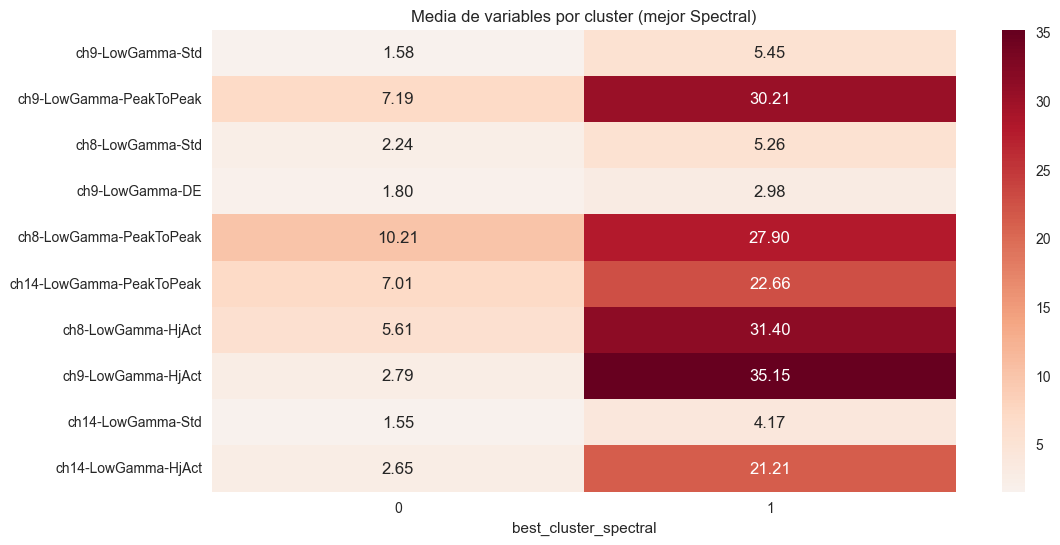

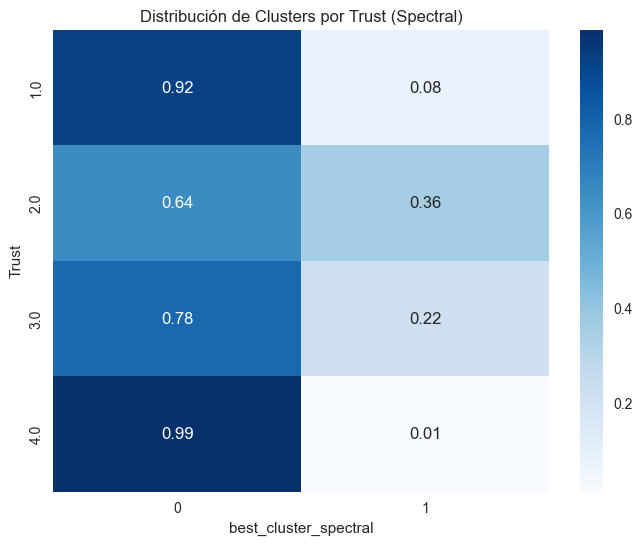

In [41]:

# Seleccionar el mejor resultado (por ARI)

best_result_spectral = max(results_Spectral_trust, key=lambda r: r['ARI'])
print("\nMejor resultado Spectral:")
print(best_result_spectral['feature_set'], best_result_spectral['method'])
print("ARI:", best_result_spectral['ARI'], "AMI:", best_result_spectral['AMI'])
print(best_result_spectral['crosstab'])

# Añadir etiquetas al dataframe
df_clustering['best_cluster_spectral'] = best_result_spectral['labels']


# Heatmap: medias de variables por cluster

cluster_means = df_clustering.groupby('best_cluster_spectral')[best_result_spectral['features']].mean()

plt.figure(figsize=(12,6))
sns.heatmap(cluster_means.T, cmap="RdBu_r", center=0, annot=True, fmt=".2f")
plt.title("Media de variables por cluster (mejor Spectral)")
plt.show()


# Heatmap: distribución de Trust por cluster

trust_cluster_dist = pd.crosstab(df_clustering["Trust"], df_clustering["best_cluster_spectral"], normalize='index')

plt.figure(figsize=(8,6))
sns.heatmap(trust_cluster_dist, cmap="Blues", annot=True, fmt=".2f")
plt.title("Distribución de Clusters por Trust (Spectral)")
plt.show()


Resumen comparativo de todos los métodos

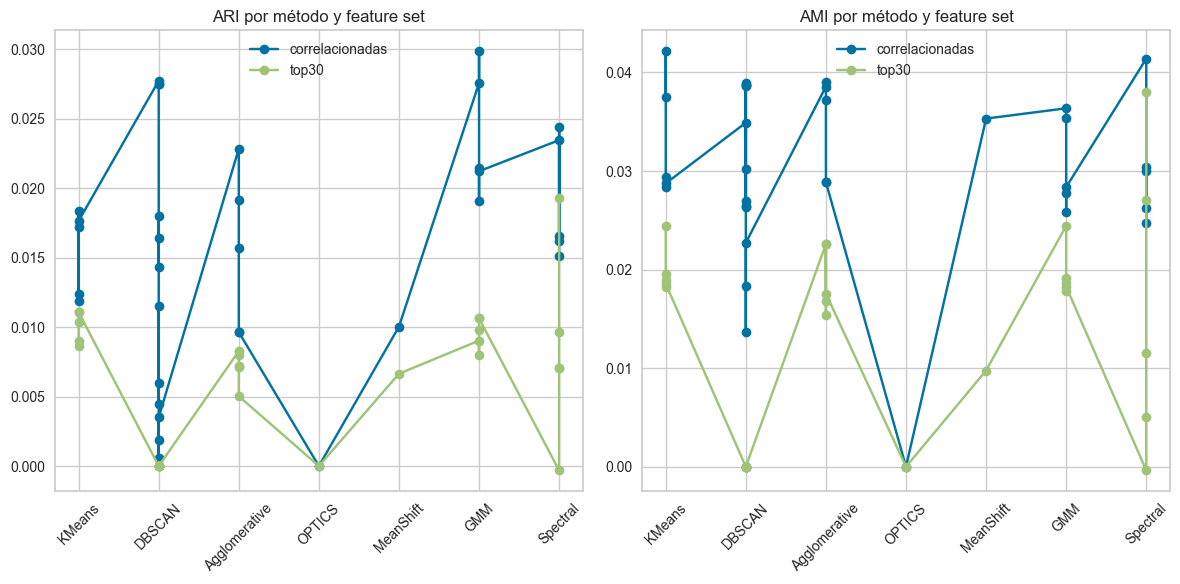

In [42]:
# Unir todos los resúmenes en un solo DataFrame
summary_all = pd.concat([
    summary_df.assign(method="KMeans"),
    summary_dbscan.assign(method="DBSCAN"),
    summary_agglo.assign(method="Agglomerative"),
    summary_optics.assign(method="OPTICS"),
    summary_MeanShift.assign(method="MeanShift"),
    summary_Gaussian.assign(method="GMM"),
    summary_Spectral.assign(method="Spectral")
], ignore_index=True)

plt.figure(figsize=(12,6))
for metric in ["ARI", "AMI"]:
    plt.subplot(1, 2, 1 if metric=="ARI" else 2)
    for fs in summary_all["feature_set"].unique():
        subset = summary_all[summary_all["feature_set"]==fs]
        plt.plot(subset["method"], subset[metric], "o-", label=fs)
    plt.xticks(rotation=45)
    plt.title(f"{metric} por método y feature set")
    plt.legend()
plt.tight_layout()
plt.show()


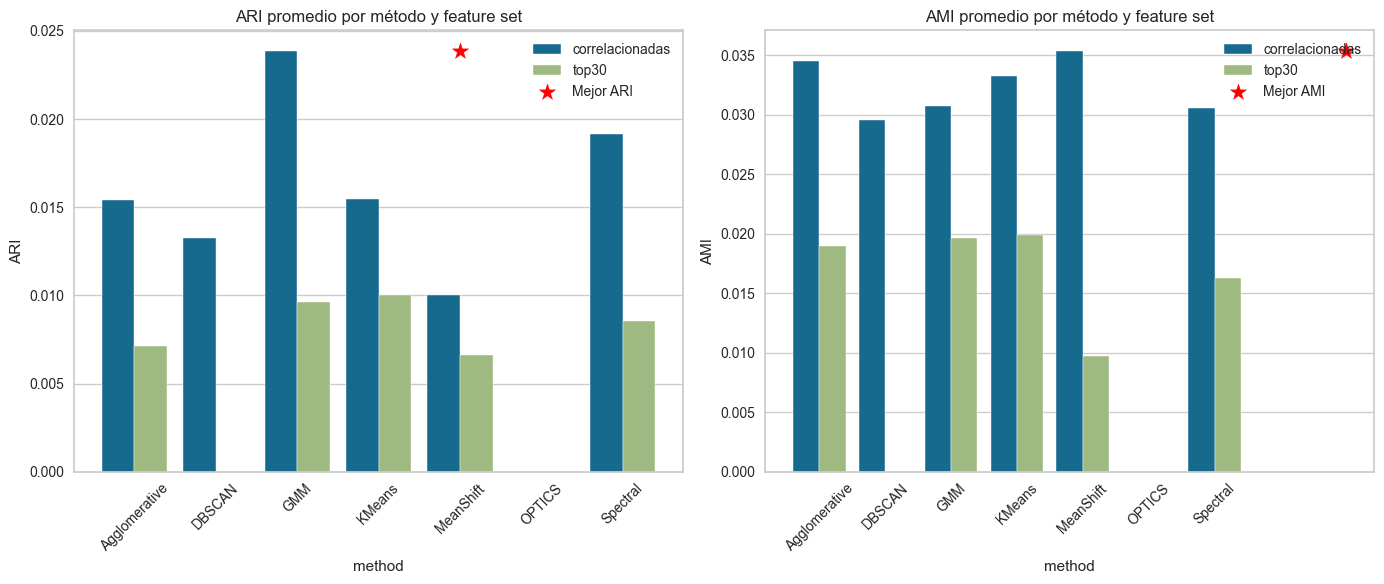

Mejor ARI: {'method': 'GMM', 'feature_set': 'correlacionadas', 'ARI': 0.023834430114382552, 'AMI': 0.030766606662946346}
Mejor AMI: {'method': 'MeanShift', 'feature_set': 'correlacionadas', 'ARI': 0.010035477164015198, 'AMI': 0.03532244027630561}


In [43]:
summary_mean = summary_all.groupby(["method","feature_set"])[["ARI","AMI"]].mean().reset_index()

# Identificar mejores resultados
best_ari = summary_mean.loc[summary_mean["ARI"].idxmax()]
best_ami = summary_mean.loc[summary_mean["AMI"].idxmax()]

plt.figure(figsize=(14,6))

# --- ARI ---
ax1 = plt.subplot(1,2,1)
sns.barplot(data=summary_mean, x="method", y="ARI", hue="feature_set", ax=ax1)
ax1.set_title("ARI promedio por método y feature set")
ax1.tick_params(axis='x', rotation=45)

# Resaltar mejor ARI
best_idx = (summary_mean["method"]==best_ari["method"]) & (summary_mean["feature_set"]==best_ari["feature_set"])
x_pos = summary_mean[best_idx].index[0]
ax1.scatter(x=x_pos, y=best_ari["ARI"], color="red", s=150, marker="*", label="Mejor ARI")
ax1.legend()

# --- AMI ---
ax2 = plt.subplot(1,2,2)
sns.barplot(data=summary_mean, x="method", y="AMI", hue="feature_set", ax=ax2)
ax2.set_title("AMI promedio por método y feature set")
ax2.tick_params(axis='x', rotation=45)

# Resaltar mejor AMI
best_idx = (summary_mean["method"]==best_ami["method"]) & (summary_mean["feature_set"]==best_ami["feature_set"])
x_pos = summary_mean[best_idx].index[0]
ax2.scatter(x=x_pos, y=best_ami["AMI"], color="red", s=150, marker="*", label="Mejor AMI")
ax2.legend()

plt.tight_layout()
plt.show()

print("Mejor ARI:", best_ari.to_dict())
print("Mejor AMI:", best_ami.to_dict())


# K-Means para base de datos eeg en crudo

Primero analizamos el conjunto de datos

In [44]:
eeg = pd.read_csv('/Users/luciarebolledo/PycharmProjects/TFG_practicas_final/markers_y_eeg_PP_NEUTRAL_CRUDO/eeg_pp_4.csv')
markers = pd.read_csv('/Users/luciarebolledo/PycharmProjects/TFG_practicas_final/markers_y_eeg_PP_NEUTRAL_CRUDO/markers_pp_NEU_4.csv')

In [45]:
print("\n=== EEG ===")
print(eeg.shape)   
print(eeg.columns)      
print(eeg.head())     



=== EEG ===
(97280, 20)
Index(['latency', 'fp1', 'fp2', 'f7', 'f3', 'fz', 'f4', 'f8', 't7', 'c3', 'cz',
       'c4', 't8', 'p7', 'p3', 'pz', 'p4', 'p8', 'o1', 'o2'],
      dtype='object')
   latency        fp1        fp2        f7         f3         fz        f4  \
0  0.00328  23.319690  21.751160  16.81343  -6.384516  17.721050  48.38033   
1  0.00719  27.059770  25.200370  20.15501 -15.702240  16.133960  53.39947   
2  0.01110  14.567210  16.693750  30.18834 -13.741070   6.869718  34.35049   
3  0.01500  -0.463504   9.623526  45.10619  -2.914778   0.788520  12.68600   
4  0.01891  -6.692658  11.927240  55.23999   6.655140   3.400757   8.08490   

          f8        t7         c3         cz         c4         t8         p7  \
0   4.577645  24.43751  -5.899403  -7.454670  20.654500   4.349786  -9.894298   
1  10.785700  27.76773   9.278098 -11.304880  32.319240   3.601472  -2.307045   
2   8.888978  17.65112   7.271563  -8.832586  21.018700  -4.539025  -7.727438   
3  -4.841935  10.0

In [46]:
print("\n=== Markers ===")
print(markers.shape)
print(markers.columns)
print(markers.head())


=== Markers ===
(233, 5)
Index(['latency', 'Date', 'marker', 'trust', 'Sample_Frecuency'], dtype='object')
   latency                     Date                 marker  trust  \
0  0.00000  2025-04-09 11:23:25.987       intro_trials_end    NaN   
1  0.79687  2025-04-09 11:23:26.784   1_1_trial_start_None    2.0   
2  0.99687  2025-04-09 11:23:26.984    1_1_automation_none    2.0   
3  2.72343  2025-04-09 11:23:28.711     1_1_trial_end_None    2.0   
4  5.20896  2025-04-09 11:23:31.196  1_1_survey_start_None    2.0   

   Sample_Frecuency  
0               256  
1               256  
2               256  
3               256  
4               256  


In [47]:
print("\nNulos EEG:")
print(eeg.isna().sum())


Nulos EEG:
latency    0
fp1        0
fp2        0
f7         0
f3         0
fz         0
f4         0
f8         0
t7         0
c3         0
cz         0
c4         0
t8         0
p7         0
p3         0
pz         0
p4         0
p8         0
o1         0
o2         0
dtype: int64


In [48]:
print("\nNulos Markers:")
print(markers.isna().sum())


Nulos Markers:
latency              0
Date                 0
marker               0
trust               33
Sample_Frecuency     0
dtype: int64


Merge

In [49]:
# Aseguramos que estén ordenados por latencia
markers = markers.sort_values("latency").reset_index(drop=True)

In [51]:
merge_eeg_markers = eeg.copy()

In [52]:
# Crear columna vacía de Trust en eeg
merge_eeg_markers ["Trust"] = None

In [53]:
# Recorremos markers desde la segunda fila
for i in range(1, len(markers)):
    start_latency = markers.loc[i-1, "latency"]
    end_latency   = markers.loc[i, "latency"]   
    trust_value   = markers.loc[i, "trust"]     

    if pd.notna(trust_value):
        mask = (
            (merge_eeg_markers["latency"] >= start_latency) &
            (merge_eeg_markers["latency"] < end_latency)
        )
        merge_eeg_markers.loc[mask, "Trust"] = trust_value

In [54]:
# Guardar el resultado
merge_eeg_markers.to_csv("eeg_pp_4_labeled.csv", index=False)

In [55]:
print(merge_eeg_markers.head(15))

    latency        fp1        fp2         f7         f3         fz         f4  \
0   0.00328  23.319690  21.751160  16.813430  -6.384516  17.721050  48.380330   
1   0.00719  27.059770  25.200370  20.155010 -15.702240  16.133960  53.399470   
2   0.01110  14.567210  16.693750  30.188340 -13.741070   6.869718  34.350490   
3   0.01500  -0.463504   9.623526  45.106190  -2.914778   0.788520  12.686000   
4   0.01891  -6.692658  11.927240  55.239990   6.655140   3.400757   8.084900   
5   0.02281  -8.300791  14.719410  53.040050   7.185923   6.106017  11.506610   
6   0.02672 -12.571000   8.185669  42.457420   1.265715   0.554635   4.587673   
7   0.03063 -17.036840  -2.872681  33.838100  -2.208595  -7.900506 -10.452490   
8   0.03453 -17.378330  -8.770775  30.382570   0.480810  -9.904863 -19.090620   
9   0.03844 -18.455730 -11.346640  25.051110   4.069523  -7.933094 -21.744110   
10  0.04235 -26.407050 -18.549980  12.289940   3.290518 -11.102560 -30.692440   
11  0.04625 -35.406310 -27.7

In [56]:
# Seleccionar solo los canales EEG (quitamos latency y Trust)
features_eeg = merge_eeg_markers.drop(columns=["latency", "Trust"])

### MODELOS 

### KMEANS

Primero vamos a aplicar los métodos del codo (Elbow) y de la silueta (Silhouette) para determinar el número óptimo de clusters en los datos EEG. Con ese valor de k entrenaremos el algoritmo KMeans y asignaremos cada muestra a un cluster. Finalmente, reduciremos la dimensionalidad con PCA para visualizar los resultados en 2D y compararlos con las etiquetas reales de confianza (Trust).

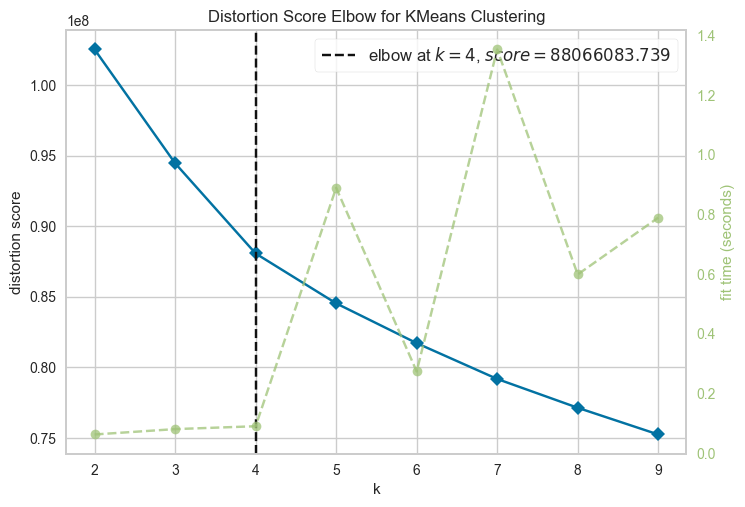

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [57]:
# Paso 1. Elbow 
model = KMeans(random_state=42)
visualizer = KElbowVisualizer(model, k=(2,10))
visualizer.fit(features_eeg.to_numpy())
visualizer.show()


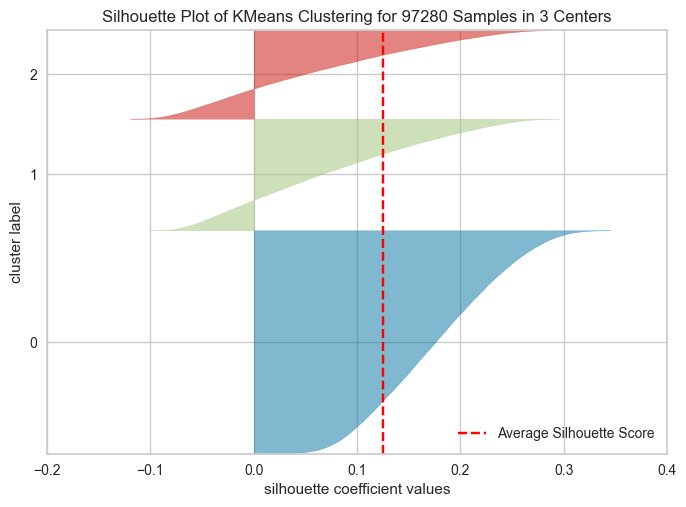

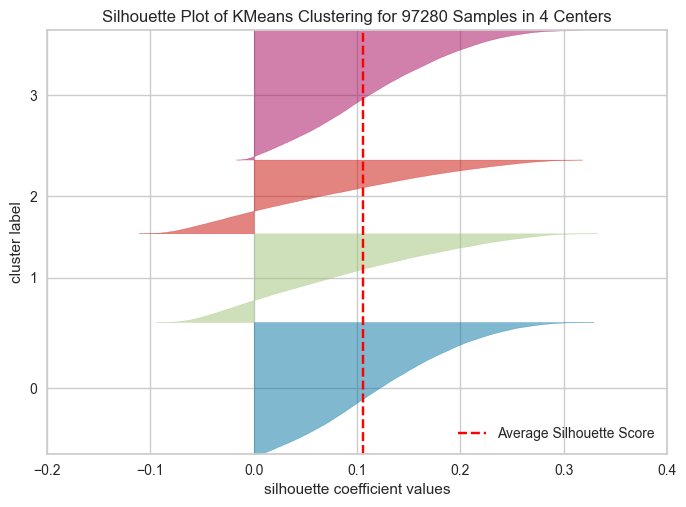

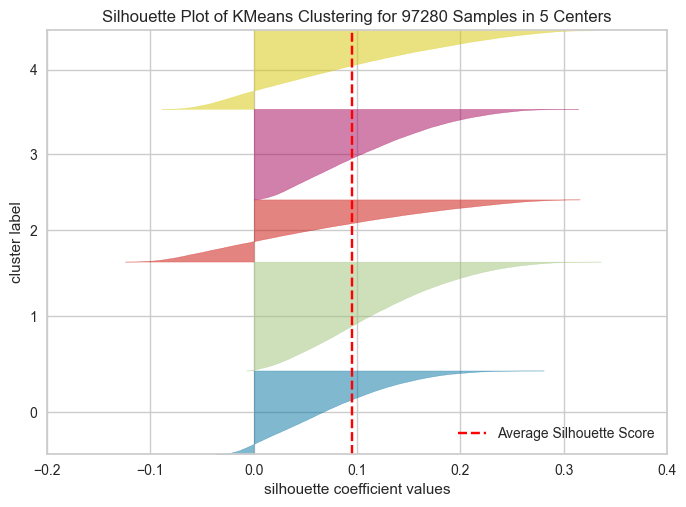

In [58]:
# Paso 2. Silhouette
from yellowbrick.cluster import SilhouetteVisualizer

for k in [3,4,5]:
    model = KMeans(n_clusters=k, random_state=42)
    visualizer = SilhouetteVisualizer(model, colors="yellowbrick")
    visualizer.fit(features_eeg.to_numpy())
    visualizer.show()


In [59]:


# Escalar
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features_eeg)

# Entrenar KMeans
kmeans3 = KMeans(n_clusters=3, random_state=42)
clusters3 = kmeans3.fit_predict(X_scaled)

df_k3 = merge_eeg_markers.copy()
df_k3["Cluster"] = clusters3


In [60]:
# Paso 3. Entrenar KMeans con el 4 elegido
kmeans4 = KMeans(n_clusters=4, random_state=42)
clusters4 = kmeans4.fit_predict(X_scaled)

df_k4 = merge_eeg_markers.copy()
df_k4["Cluster"] = clusters4

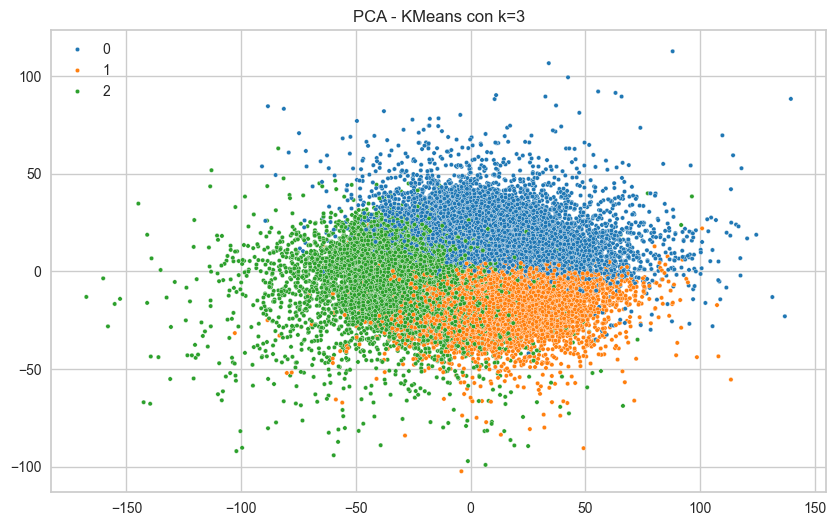

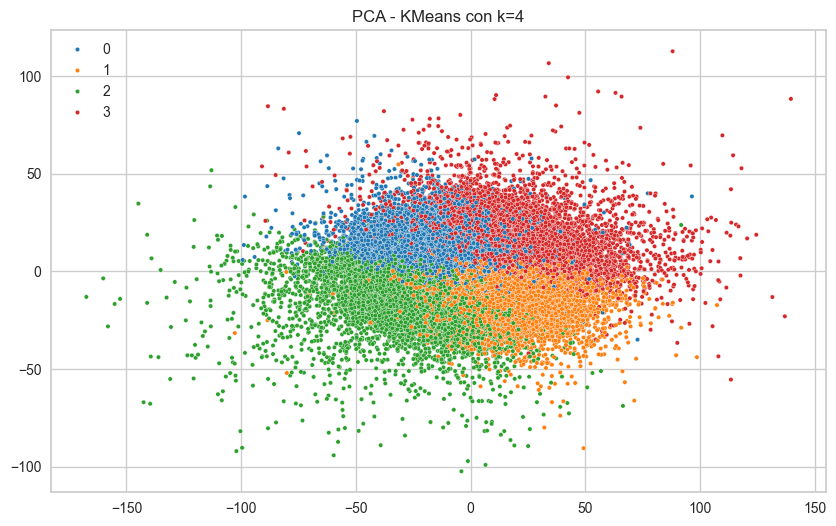

In [61]:
# Paso 4. PCA para visualizar
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

def plot_pca_clusters(data, labels, k):
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(data)
    plt.figure(figsize=(10,6))
    sns.scatterplot(x=reduced[:,0], y=reduced[:,1], hue=labels, palette="tab10", s=10)
    plt.title(f"PCA - KMeans con k={k}")
    plt.show()

plot_pca_clusters(features_eeg, clusters3, 3)
plot_pca_clusters(features_eeg, clusters4, 4)

In [62]:

# Quitamos NaN de Trust
mask = ~merge_eeg_markers["Trust"].isna()

# Para k=3
ari3 = adjusted_rand_score(merge_eeg_markers["Trust"][mask], clusters3[mask])
ami3 = adjusted_mutual_info_score(merge_eeg_markers["Trust"][mask], clusters3[mask])

print(f"K=3 → ARI: {ari3:.4f}, AMI: {ami3:.4f}")

# Para k=4
ari4 = adjusted_rand_score(merge_eeg_markers["Trust"][mask], clusters4[mask])
ami4 = adjusted_mutual_info_score(merge_eeg_markers["Trust"][mask], clusters4[mask])

print(f"K=4 → ARI: {ari4:.4f}, AMI: {ami4:.4f}")


K=3 → ARI: 0.0003, AMI: 0.0006
K=4 → ARI: -0.0013, AMI: 0.0010


## Miramos las variables unicamnete con PSD por zonas cerebrales

In [ ]:

# 1. Cargar datos de un paciente

df = pd.read_csv("eeg_features_session01_binarias/eeg_features_4.csv")


# 2. Mapeo de canales a regiones

channel_region = {
    "ch1": "Frontal", "ch2": "Frontal", "ch3": "Frontal", "ch4": "Frontal",
    "ch5": "Frontal", "ch6": "Frontal", "ch7": "Frontal",
    "ch8": "Temporal", "ch12": "Temporal", "ch13": "Temporal", "ch17": "Temporal",
    "ch9": "Central", "ch10": "Central", "ch11": "Central",
    "ch14": "Parietal", "ch15": "Parietal", "ch16": "Parietal",
    "ch18": "Occipital", "ch19": "Occipital"
}


# 3. Crear columnas región-banda

psd_cols = [c for c in df.columns if "-PSD" in c]

region_band_data = {}
for col in psd_cols:
    ch, band, _ = col.split("-")  
    if ch in channel_region:
        region = channel_region[ch]
        new_col = f"{region}-{band}"
        if new_col not in region_band_data:
            region_band_data[new_col] = []
        region_band_data[new_col].append(col)

# Promediamos canales por región-banda
for new_col, cols in region_band_data.items():
    df[new_col] = df[cols].mean(axis=1)

region_band_cols = list(region_band_data.keys())


# 4. Comparar Trust bajo vs alto

trust_means = df.groupby("Trust")[region_band_cols].mean()

tmin, tmax = trust_means.index.min(), trust_means.index.max()
diff = trust_means.loc[tmax] - trust_means.loc[tmin]
diff = diff.sort_values(ascending=False)

print(f"Paciente 4 | Trust {tmin} → {tmax}")
print("\n=== Regiones/Bandas que más SUBEN ===")
print(diff.head(10))
print("\n=== Regiones/Bandas que más BAJAN ===")
print(diff.tail(10))


# 5. Visualización en heatmap

diff_matrix = diff.reset_index()
diff_matrix[["Region", "Banda"]] = diff_matrix["index"].str.split("-", n=1, expand=True)
diff_pivot = diff_matrix.pivot(index="Region", columns="Banda", values=0)

plt.figure(figsize=(10,6))
sns.heatmap(diff_pivot, cmap="RdBu_r", center=0, annot=True, fmt=".2f")
plt.title(f"Diferencia Trust {tmin} → {tmax} (Paciente 4)")
plt.show()


¿Hay NaN en Trust?: True
Total NaN en Trust: 320
Valores únicos en Trust: [nan  2.  3.  4.  1.]

Tamaño original: 2320
Tamaño después de limpiar: 2000
Distribución de Trust:
Trust
1.0    1000
3.0     550
2.0     300
4.0     150
Name: count, dtype: int64

K=2
Silhouette Score: 0.772
ARI: 0.028
AMI: 0.027

K=3
Silhouette Score: 0.671
ARI: 0.038
AMI: 0.028

K=4
Silhouette Score: 0.468
ARI: 0.050
AMI: 0.030

K=5
Silhouette Score: 0.564
ARI: 0.056
AMI: 0.035

K=6
Silhouette Score: 0.467
ARI: 0.050
AMI: 0.031


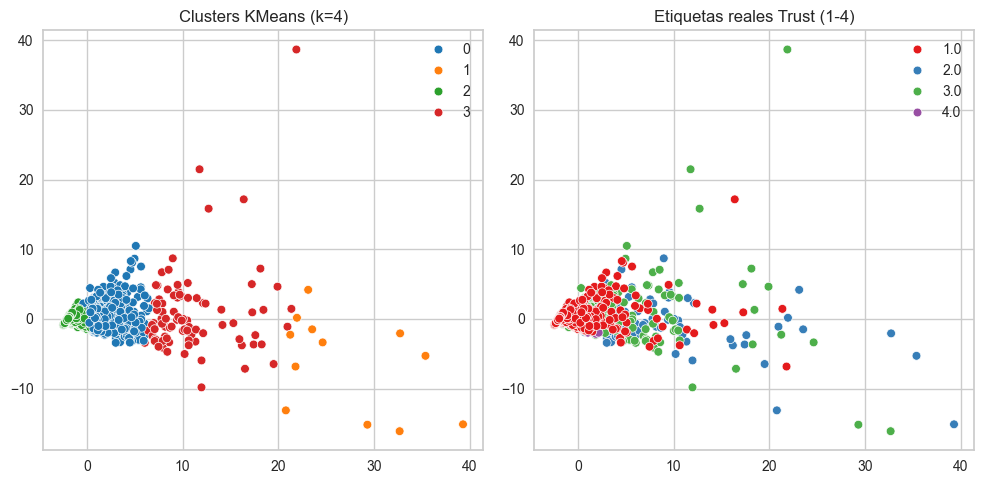

In [63]:

# 1. Cargar datos de un paciente

df = pd.read_csv("/Users/luciarebolledo/PycharmProjects/TFG_practicas_final/eeg_features_session01_binarias/eeg_features_4.csv")


# 2. Mapeo de canales a regiones

channel_region = {
    "ch1": "Frontal", "ch2": "Frontal", "ch3": "Frontal", "ch4": "Frontal",
    "ch5": "Frontal", "ch6": "Frontal", "ch7": "Frontal",
    "ch8": "Temporal", "ch12": "Temporal", "ch13": "Temporal", "ch17": "Temporal",
    "ch9": "Central", "ch10": "Central", "ch11": "Central",
    "ch14": "Parietal", "ch15": "Parietal", "ch16": "Parietal",
    "ch18": "Occipital", "ch19": "Occipital"
}


# 3. Crear columnas región-banda

psd_cols = [c for c in df.columns if "-PSD" in c]

region_band_data = {}
for col in psd_cols:
    parts = col.split("-")
    if len(parts) == 3:  # ej. ch7-Delta-PSD
        ch, band, _ = parts
        if ch in channel_region:
            region = channel_region[ch]
            new_col = f"{region}-{band}"
            region_band_data.setdefault(new_col, []).append(col)

# Promediamos canales por región-banda
for new_col, cols in region_band_data.items():
    df[new_col] = df[cols].mean(axis=1)

region_band_cols = list(region_band_data.keys())


# 4. Limpiar NaN en Trust

print("¿Hay NaN en Trust?:", df["Trust"].isna().any())
print("Total NaN en Trust:", df["Trust"].isna().sum())
print("Valores únicos en Trust:", df["Trust"].unique())

df_clean = df.dropna(subset=["Trust"]).copy()

print("\nTamaño original:", len(df))
print("Tamaño después de limpiar:", len(df_clean))
print("Distribución de Trust:")
print(df_clean["Trust"].value_counts())


# 5. Preparar features y target

X = df_clean[region_band_cols].values
y_true = df_clean["Trust"].values  # niveles 1,2,3,4

# Reemplazar posibles NaN en features (por media de cada columna)
X = np.nan_to_num(X, nan=np.nanmean(X))

# Escalado
X_scaled = StandardScaler().fit_transform(X)


# 6. Clustering con KMeans y métricas

for k in [2, 3, 4, 5, 6]:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    clusters = km.fit_predict(X_scaled)
    
    # Métricas internas
    sil = silhouette_score(X_scaled, clusters)
    
    # Métricas externas (comparando con Trust real)
    ari = adjusted_rand_score(y_true, clusters)
    ami = adjusted_mutual_info_score(y_true, clusters)
    
    print(f"\nK={k}")
    print(f"Silhouette Score: {sil:.3f}")
    print(f"ARI: {ari:.3f}")
    print(f"AMI: {ami:.3f}")


# 7. (Opcional) Visualización con PCA 2D

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10,5))

# Clusters de KMeans con k=4 (ejemplo)
km = KMeans(n_clusters=4, random_state=42, n_init=10)
clusters = km.fit_predict(X_scaled)

plt.subplot(1,2,1)
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=clusters, palette="tab10", s=40)
plt.title("Clusters KMeans (k=4)")

# Etiquetas reales Trust
plt.subplot(1,2,2)
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=y_true, palette="Set1", s=40)
plt.title("Etiquetas reales Trust (1-4)")

plt.tight_layout()
plt.show()


In [64]:

# 1. Features a usar (región-banda)

X = df_clean[region_band_cols].values
y_true = df_clean["Binary_Trust"].values   

# Escalar
X_scaled = StandardScaler().fit_transform(X)


# 2. Probar clustering con KMeans

for k in [2, 3, 4]:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    clusters = km.fit_predict(X_scaled)
    
    # Métricas internas
    sil = silhouette_score(X_scaled, clusters)
    
    # Métricas externas (comparando con Binary_Trust real)
    ari = adjusted_rand_score(y_true, clusters)
    ami = adjusted_mutual_info_score(y_true, clusters)
    
    print(f"\nK={k}")
    print(f"Silhouette Score: {sil:.3f}")
    print(f"ARI: {ari:.3f}")
    print(f"AMI: {ami:.3f}")



K=2
Silhouette Score: 0.772
ARI: 0.004
AMI: 0.024

K=3
Silhouette Score: 0.671
ARI: 0.006
AMI: 0.020

K=4
Silhouette Score: 0.468
ARI: 0.010
AMI: 0.022


In [65]:

# 1. Features y target

X = df_clean[region_band_cols].values
y_true = df_clean["Trust"].values   

# Reemplazar posibles NaN en features
X = np.nan_to_num(X, nan=np.nanmean(X))

# Escalar
X_scaled = StandardScaler().fit_transform(X)


# 2. Probar clustering con GMM

for k in [2, 3, 4, 5, 6]:
    gmm = GaussianMixture(n_components=k, random_state=42, n_init=5)
    clusters = gmm.fit_predict(X_scaled)
    
    # Métricas internas
    sil = silhouette_score(X_scaled, clusters)
    
    # Métricas externas
    ari = adjusted_rand_score(y_true, clusters)
    ami = adjusted_mutual_info_score(y_true, clusters)
    
    print(f"\nK={k} (GMM)")
    print(f"Silhouette Score: {sil:.3f}")
    print(f"ARI: {ari:.3f}")
    print(f"AMI: {ami:.3f}")



K=2 (GMM)
Silhouette Score: 0.180
ARI: 0.006
AMI: 0.012

K=3 (GMM)
Silhouette Score: 0.152
ARI: 0.009
AMI: 0.012

K=4 (GMM)
Silhouette Score: 0.118
ARI: 0.048
AMI: 0.033

K=5 (GMM)
Silhouette Score: 0.097
ARI: 0.031
AMI: 0.028

K=6 (GMM)
Silhouette Score: 0.116
ARI: 0.044
AMI: 0.028


Análisis estadístico de la actividad LowGamma por región cerebral en relación con los niveles de confianza

Features LowGamma generadas: ['Frontal-LowGamma', 'Temporal-LowGamma', 'Central-LowGamma', 'Parietal-LowGamma', 'Occipital-LowGamma']

=== Frontal-LowGamma ===
Media Trust 1: 27.635
Media Trust 2: 22.139
Media Trust 3: 23.646
Media Trust 4: 18.948
ANOVA p-value: 9.420232412694256e-05
Kruskal-Wallis p-value: 9.105802220006356e-06

=== Temporal-LowGamma ===
Media Trust 1: 14.664
Media Trust 2: 27.718
Media Trust 3: 18.294
Media Trust 4: 10.283
ANOVA p-value: 2.9485654046103362e-28
Kruskal-Wallis p-value: 1.5013212834171938e-33

=== Central-LowGamma ===
Media Trust 1: 12.326
Media Trust 2: 15.863
Media Trust 3: 16.337
Media Trust 4: 7.879
ANOVA p-value: 4.220997286314193e-06
Kruskal-Wallis p-value: 5.032230164192218e-08

=== Parietal-LowGamma ===
Media Trust 1: 5.252
Media Trust 2: 12.232
Media Trust 3: 10.320
Media Trust 4: 3.585
ANOVA p-value: 5.286392998907555e-13
Kruskal-Wallis p-value: 7.127050307600188e-13

=== Occipital-LowGamma ===
Media Trust 1: 6.035
Media Trust 2: 9.197
Media T

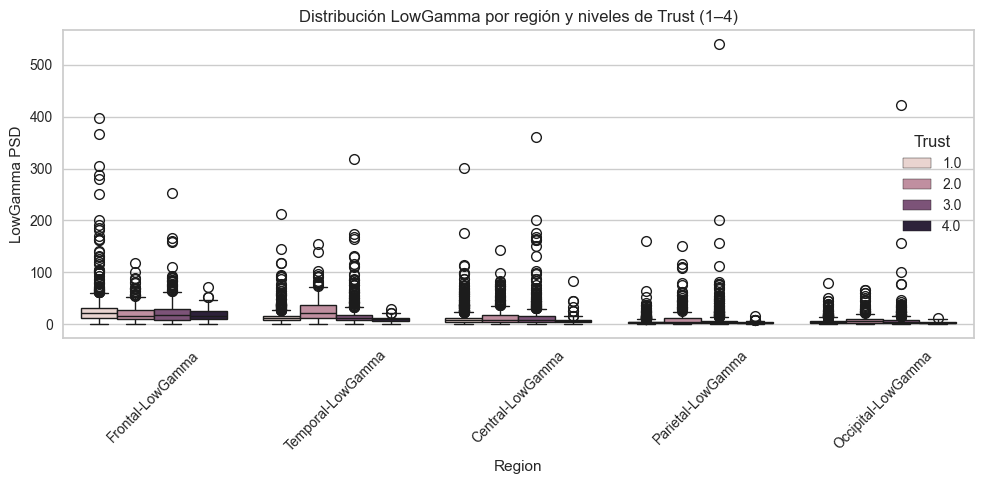

In [67]:
from scipy.stats import f_oneway
from scipy.stats import kruskal

# 1. Seleccionar columnas LowGamma
lowgamma_cols = [c for c in df.columns if "LowGamma-PSD" in c]


# 2. Crear columnas región-LowGamma
region_band_data = {}
for col in lowgamma_cols:
    parts = col.split("-")
    if len(parts) == 3:  
        ch, band, _ = parts
        if ch in channel_region:
            region = channel_region[ch]
            new_col = f"{region}-LowGamma"
            region_band_data.setdefault(new_col, []).append(col)

# Promedio LowGamma por región
for new_col, cols in region_band_data.items():
    df[new_col] = df[cols].mean(axis=1)

lowgamma_region_cols = list(region_band_data.keys())
print("Features LowGamma generadas:", lowgamma_region_cols)


# 3. Comparación estadística entre Trust 1–4
df_clean = df.dropna(subset=["Trust"]).copy()

for col in lowgamma_region_cols:
    groups = [df_clean[df_clean["Trust"] == t][col] for t in sorted(df_clean["Trust"].unique())]
    
    # ANOVA (paramétrico)
    f_stat, p_anova = f_oneway(*groups)
    
    # Kruskal-Wallis (no paramétrico)
    h_stat, p_kw = kruskal(*groups)
    
    print(f"\n=== {col} ===")
    for t in sorted(df_clean["Trust"].unique()):
        print(f"Media Trust {int(t)}: {df_clean[df_clean['Trust']==t][col].mean():.3f}")
    print("ANOVA p-value:", p_anova)
    print("Kruskal-Wallis p-value:", p_kw)


# 4. Visualización por región y Trust
plt.figure(figsize=(10,5))
melted = df_clean.melt(id_vars="Trust", value_vars=lowgamma_region_cols,
                       var_name="Region", value_name="LowGamma PSD")
sns.boxplot(data=melted, x="Region", y="LowGamma PSD", hue="Trust")
plt.title("Distribución LowGamma por región y niveles de Trust (1–4)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


       Frontal-LowGamma  Temporal-LowGamma  Central-LowGamma  \
Trust                                                          
1.0           27.634713          14.664117         12.326147   
2.0           22.138788          27.718277         15.863282   
3.0           23.646195          18.294241         16.336733   
4.0           18.947924          10.283086          7.878596   

       Parietal-LowGamma  Occipital-LowGamma  
Trust                                         
1.0             5.251652            6.035408  
2.0            12.232217            9.196885  
3.0            10.320484            8.061567  
4.0             3.584704            3.938365  


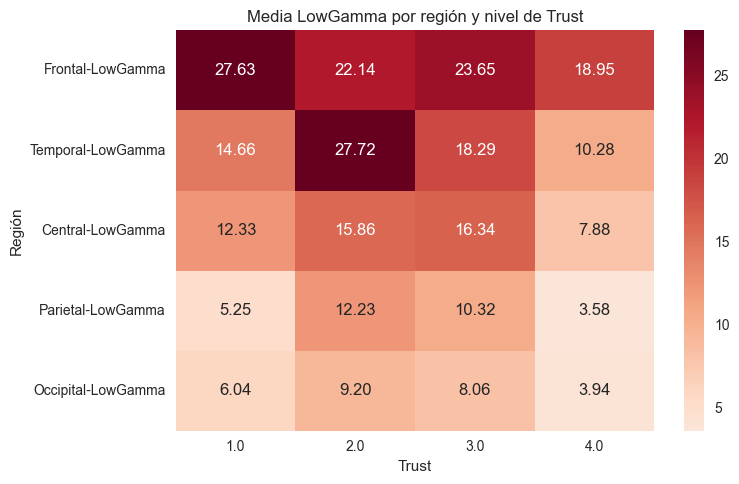

In [68]:
# 1. Calcular medias por Trust y región
heatmap_data = df_clean.groupby("Trust")[lowgamma_region_cols].mean()

print(heatmap_data)


# 2. Dibujar Heatmap
plt.figure(figsize=(8,5))
sns.heatmap(heatmap_data.T, cmap="RdBu_r", annot=True, fmt=".2f", center=0)

plt.title("Media LowGamma por región y nivel de Trust")
plt.xlabel("Trust")
plt.ylabel("Región")
plt.tight_layout()
plt.show()


In [69]:
# 1. Preparar features y target
X = df_clean[lowgamma_region_cols].values  
y_true = df_clean["Trust"].values          

# Escalar
X_scaled = StandardScaler().fit_transform(X)


# 2. KMeans clustering
print("=== KMeans ===")
for k in [2,3,4,5]:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    clusters = km.fit_predict(X_scaled)

    sil = silhouette_score(X_scaled, clusters)
    ari = adjusted_rand_score(y_true, clusters)
    ami = adjusted_mutual_info_score(y_true, clusters)

    print(f"K={k} | Silhouette={sil:.3f}, ARI={ari:.3f}, AMI={ami:.3f}")


# 3. GMM clustering
print("\n=== GMM ===")
for k in [2,3,4,5]:
    gmm = GaussianMixture(n_components=k, random_state=42, n_init=5)
    clusters = gmm.fit_predict(X_scaled)

    sil = silhouette_score(X_scaled, clusters)
    ari = adjusted_rand_score(y_true, clusters)
    ami = adjusted_mutual_info_score(y_true, clusters)

    print(f"K={k} | Silhouette={sil:.3f}, ARI={ari:.3f}, AMI={ami:.3f}")


=== KMeans ===
K=2 | Silhouette=0.762, ARI=0.019, AMI=0.015
K=3 | Silhouette=0.738, ARI=0.023, AMI=0.018
K=4 | Silhouette=0.654, ARI=0.030, AMI=0.023
K=5 | Silhouette=0.646, ARI=0.032, AMI=0.033

=== GMM ===
K=2 | Silhouette=0.590, ARI=0.047, AMI=0.038
K=3 | Silhouette=0.550, ARI=0.044, AMI=0.034
K=4 | Silhouette=0.326, ARI=0.040, AMI=0.032
K=5 | Silhouette=0.235, ARI=0.031, AMI=0.033


Bandas más relevantes

   Temporal-LowGamma  Frontal-Alpha  Frontal-Beta
0         202.750680      12.914864     20.566921
1         145.305861       6.038983      8.372971
2         117.437584       0.208999      2.298199
3          99.930813       1.902977      7.605572
4          67.315562       6.407641      9.182807

=== Temporal-LowGamma ===
Media Trust 1: 14.664
Media Trust 2: 27.718
Media Trust 3: 18.294
Media Trust 4: 10.283
ANOVA p-value: 2.9485654046103362e-28
Kruskal-Wallis p-value: 1.5013212834171938e-33

=== Frontal-Alpha ===
Media Trust 1: 0.772
Media Trust 2: 2.609
Media Trust 3: 1.361
Media Trust 4: 0.394
ANOVA p-value: 1.1357247050343076e-20
Kruskal-Wallis p-value: 2.1464630815358556e-10

=== Frontal-Beta ===
Media Trust 1: 3.142
Media Trust 2: 4.314
Media Trust 3: 3.422
Media Trust 4: 2.047
ANOVA p-value: 4.962275536676105e-08
Kruskal-Wallis p-value: 3.1469090190711797e-06


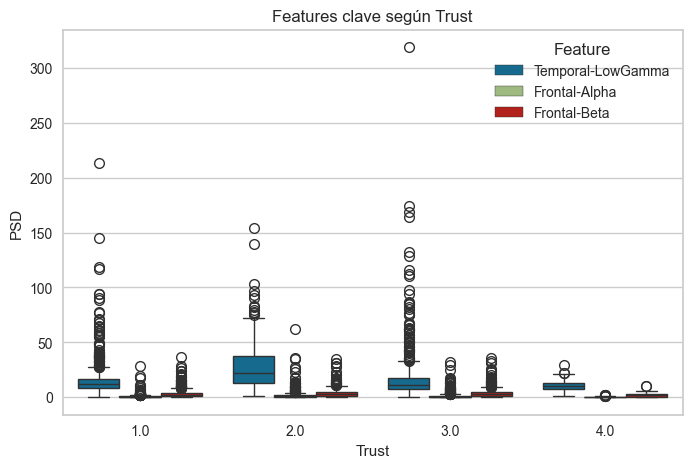

In [70]:

# 1. Seleccionar columnas relevantes

alpha_cols = [c for c in df.columns if "-Alpha-PSD" in c]
beta_cols = [c for c in df.columns if "-Beta-PSD" in c]
lowgamma_cols = [c for c in df.columns if "-LowGamma-PSD" in c]


# 2. Agregar por regiones

def region_mean(cols, region):
    region_cols = [c for c in cols if any(ch in c for ch in channel_region if channel_region[ch] == region)]
    return df[region_cols].mean(axis=1) if region_cols else None

df["Frontal-Alpha"] = region_mean(alpha_cols, "Frontal")
df["Frontal-Beta"] = region_mean(beta_cols, "Frontal")
df["Temporal-LowGamma"] = region_mean(lowgamma_cols, "Temporal")

features_interest = ["Temporal-LowGamma", "Frontal-Alpha", "Frontal-Beta"]

print(df[features_interest].head())


# 3. Estadística descriptiva

df_clean = df.dropna(subset=["Trust"] + features_interest).copy()

for col in features_interest:
    groups = [df_clean[df_clean["Trust"] == t][col] for t in sorted(df_clean["Trust"].unique())]
    
    from scipy.stats import f_oneway, kruskal
    f_stat, p_anova = f_oneway(*groups)
    h_stat, p_kw = kruskal(*groups)
    
    print(f"\n=== {col} ===")
    for t in sorted(df_clean["Trust"].unique()):
        print(f"Media Trust {int(t)}: {df_clean[df_clean['Trust']==t][col].mean():.3f}")
    print("ANOVA p-value:", p_anova)
    print("Kruskal-Wallis p-value:", p_kw)


# 4. Visualización


plt.figure(figsize=(8,5))
melted = df_clean.melt(id_vars="Trust", value_vars=features_interest,
                       var_name="Feature", value_name="PSD")
sns.boxplot(data=melted, x="Trust", y="PSD", hue="Feature")
plt.title("Features clave según Trust")
plt.show()


       Temporal-LowGamma  Frontal-Alpha  Frontal-Beta
Trust                                                
1.0            14.664117       0.772373      3.141591
2.0            27.718277       2.609441      4.314168
3.0            18.294241       1.360850      3.421611
4.0            10.283086       0.394187      2.047088


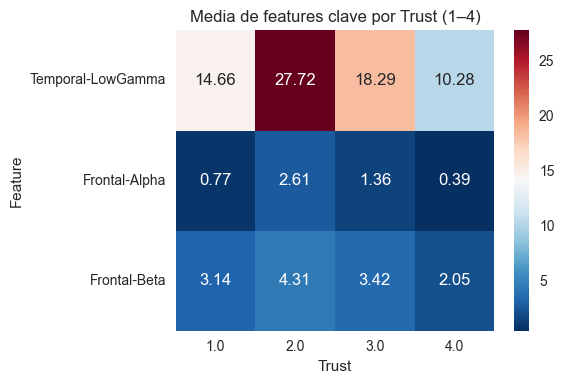

In [71]:

# 1. Calcular medias por Trust

heatmap_interest = df_clean.groupby("Trust")[features_interest].mean()

print(heatmap_interest)


# 2. Dibujar Heatmap

plt.figure(figsize=(6,4))
sns.heatmap(heatmap_interest.T, cmap="RdBu_r", annot=True, fmt=".2f")

plt.title("Media de features clave por Trust (1–4)")
plt.xlabel("Trust")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


In [72]:

# 1. Seleccionar solo columnas PSD

psd_cols = [c for c in df.columns if "-PSD" in c]

df_clean = df.dropna(subset=["Trust"] + psd_cols).copy()


# 2. Estudio estadístico por cada feature PSD

results = []

for col in psd_cols:
    groups = [df_clean[df_clean["Trust"] == t][col] for t in sorted(df_clean["Trust"].unique())]
    
    # ANOVA
    try:
        f_stat, p_anova = f_oneway(*groups)
    except:
        p_anova = None
    
    # Kruskal-Wallis
    try:
        h_stat, p_kw = kruskal(*groups)
    except:
        p_kw = None
    
    # Medias por Trust
    means = [df_clean[df_clean["Trust"] == t][col].mean() for t in sorted(df_clean["Trust"].unique())]
    
    results.append({
        "Feature": col,
        "Mean_Trust1": means[0],
        "Mean_Trust2": means[1],
        "Mean_Trust3": means[2],
        "Mean_Trust4": means[3],
        "ANOVA_p": p_anova,
        "Kruskal_p": p_kw
    })


# 3. Guardar resultados en DataFrame

df_stats = pd.DataFrame(results)

# Ordenar por significancia (p-value más bajo)
df_stats = df_stats.sort_values(by="Kruskal_p")

# Mostrar top 10
print(df_stats.head(10))

# (Opcional: exportar a Excel/CSV para análisis completo)
df_stats.to_csv("estadistica_psd_por_trust.csv", index=False)


               Feature  Mean_Trust1  Mean_Trust2  Mean_Trust3  Mean_Trust4  \
77   ch13-LowGamma-PSD    20.507454    51.689158    20.775497    10.891666   
53    ch9-LowGamma-PSD     5.006467    15.381119    11.719319     2.314715   
47    ch8-LowGamma-PSD     7.310878    15.496909    12.381737     5.466568   
107  ch18-LowGamma-PSD     5.955099    10.337325     8.671293     3.578516   
76       ch13-Beta-PSD     5.469047    14.526517     5.549538     3.473294   
83   ch14-LowGamma-PSD     3.860264     9.614883     8.536064     2.424684   
74      ch13-Alpha-PSD     1.396725     5.251427     1.788546     0.804093   
75      ch13-Sigma-PSD     0.400665     1.985147     0.440264     0.264135   
35    ch6-LowGamma-PSD    20.745579    13.330161    16.033678    13.180406   
29    ch5-LowGamma-PSD     8.213487     5.737850     6.466618     5.263141   

          ANOVA_p     Kruskal_p  
77   7.403258e-45  3.909018e-48  
53   6.926394e-20  1.382224e-39  
47   4.864633e-18  7.600954e-32  
107  

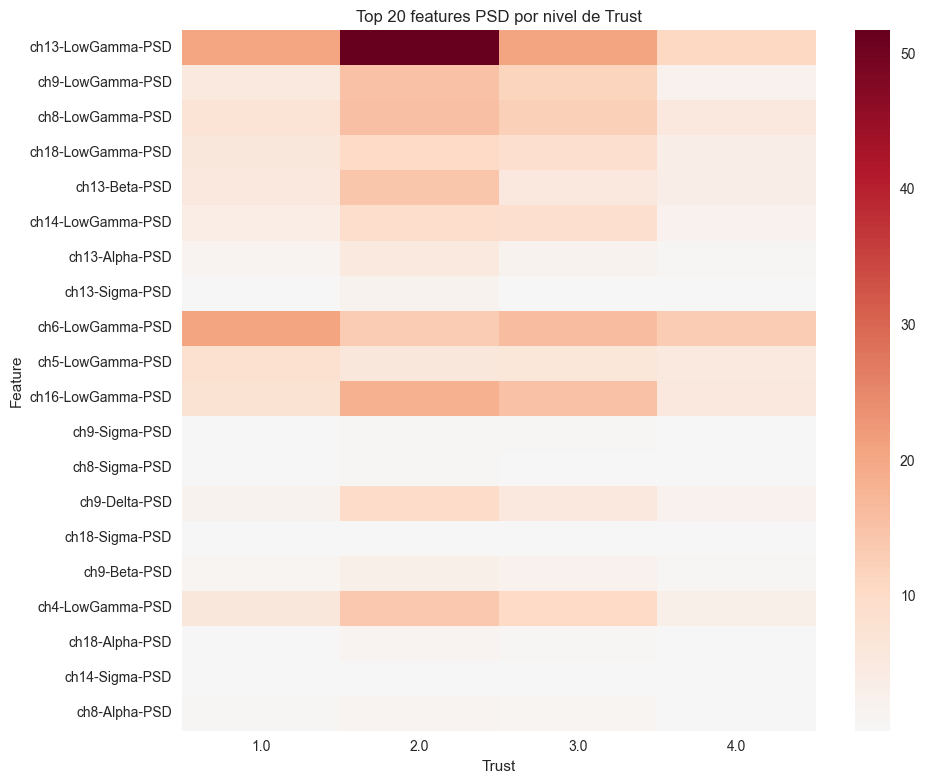

In [73]:
# Seleccionar las top 20 features más significativas
top_features = df_stats.head(20)["Feature"]

heatmap_data = df_clean.groupby("Trust")[top_features].mean().T

plt.figure(figsize=(10,8))
sns.heatmap(heatmap_data, cmap="RdBu_r", annot=False, center=0)
plt.title("Top 20 features PSD por nivel de Trust")
plt.xlabel("Trust")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


In [77]:
channel_region = {
    "ch1": "Frontal", "ch2": "Frontal", "ch3": "Frontal", "ch4": "Frontal",
    "ch5": "Frontal", "ch6": "Frontal", "ch7": "Frontal",
    "ch8": "Temporal", "ch12": "Temporal", "ch13": "Temporal", "ch17": "Temporal",
    "ch9": "Central", "ch10": "Central", "ch11": "Central",
    "ch14": "Parietal", "ch15": "Parietal", "ch16": "Parietal",
    "ch18": "Occipital", "ch19": "Occipital"
}


In [78]:

# 1. Crear variables región-banda

psd_cols = [c for c in df.columns if "-PSD" in c]

region_band_data = {}
for col in psd_cols:
    parts = col.split("-")
    if len(parts) == 3:  # ej. ch7-Delta-PSD
        ch, band, _ = parts
        if ch in channel_region:
            region = channel_region[ch]
            new_col = f"{region}-{band}"
            region_band_data.setdefault(new_col, []).append(col)

# Agregar promedios por región-banda
for new_col, cols in region_band_data.items():
    df[new_col] = df[cols].mean(axis=1)

region_band_cols = list(region_band_data.keys())


# 2. Estudio estadístico por región-banda

df_clean = df.dropna(subset=["Trust"] + region_band_cols).copy()

results = []
for col in region_band_cols:
    groups = [df_clean[df_clean["Trust"] == t][col] for t in sorted(df_clean["Trust"].unique())]

    # ANOVA
    try:
        f_stat, p_anova = f_oneway(*groups)
    except:
        p_anova = None

    # Kruskal-Wallis
    try:
        h_stat, p_kw = kruskal(*groups)
    except:
        p_kw = None

    # Medias por Trust
    means = [df_clean[df_clean["Trust"] == t][col].mean() for t in sorted(df_clean["Trust"].unique())]

    results.append({
        "Region-Band": col,
        "Mean_Trust1": means[0],
        "Mean_Trust2": means[1],
        "Mean_Trust3": means[2],
        "Mean_Trust4": means[3],
        "ANOVA_p": p_anova,
        "Kruskal_p": p_kw
    })


# 3. Guardar y mostrar

df_stats_regions = pd.DataFrame(results).sort_values(by="Kruskal_p")
print(df_stats_regions.head(20))

df_stats_regions.to_csv("estadistica_psd_por_region.csv", index=False)


           Region-Band  Mean_Trust1  Mean_Trust2  Mean_Trust3  Mean_Trust4  \
11   Temporal-LowGamma    14.664117    27.718277    18.294241    10.283086   
10       Temporal-Beta     3.205961     6.460204     3.729356     2.179382   
8       Temporal-Alpha     0.920615     3.318276     1.718009     0.465025   
23   Parietal-LowGamma     5.251652    12.232217    10.320484     3.584704   
9       Temporal-Sigma     0.242995     1.010501     0.464657     0.138793   
29  Occipital-LowGamma     6.035408     9.196885     8.061567     3.938365   
27     Occipital-Sigma     0.085074     0.362980     0.187327     0.053925   
20      Parietal-Alpha     0.522921     2.091461     1.054887     0.235284   
7       Temporal-Theta     1.973232     5.226899     3.587392     1.358901   
22       Parietal-Beta     1.202513     2.425451     2.052462     0.680892   
26     Occipital-Alpha     0.389704     1.477636     0.610603     0.193051   
21      Parietal-Sigma     0.100969     0.470761     0.280502   

Archivos cargados: 15 pacientes
Tamaño total del DataFrame combinado: (63, 30)


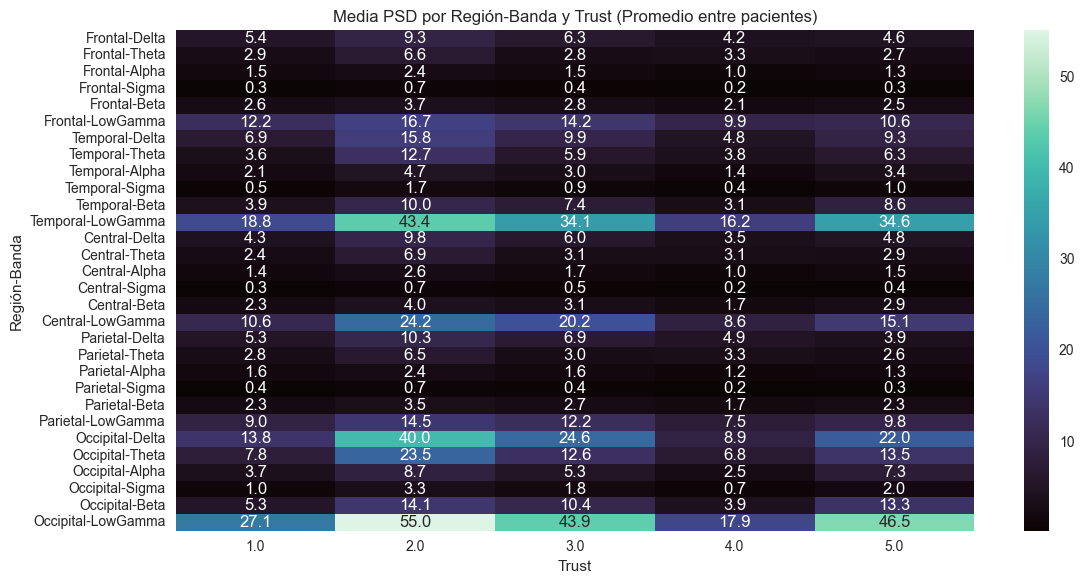


=== Top 10 diferencias significativas (Kruskal) ===
            Feature   ANOVA_p  Kruskal_p
18   Parietal-Delta  0.602573   0.417357
19   Parietal-Theta  0.451297   0.464817
0     Frontal-Delta  0.580287   0.519596
1     Frontal-Theta  0.457231   0.543901
13    Central-Theta  0.540121   0.555772
7    Temporal-Theta  0.599548   0.610085
25  Occipital-Theta  0.651181   0.616379
6    Temporal-Delta  0.678515   0.622308
20   Parietal-Alpha  0.673463   0.622372
22    Parietal-Beta  0.728078   0.638273

=== Correlaciones más altas ===
               Feature  Correlation
28      Occipital-Beta     0.196989
10       Temporal-Beta     0.131368
26     Occipital-Alpha     0.061700
11   Temporal-LowGamma     0.058492
29  Occipital-LowGamma     0.016177
27     Occipital-Sigma    -0.075444
8       Temporal-Alpha    -0.083649
25     Occipital-Theta    -0.126382
9       Temporal-Sigma    -0.147401
7       Temporal-Theta    -0.150670


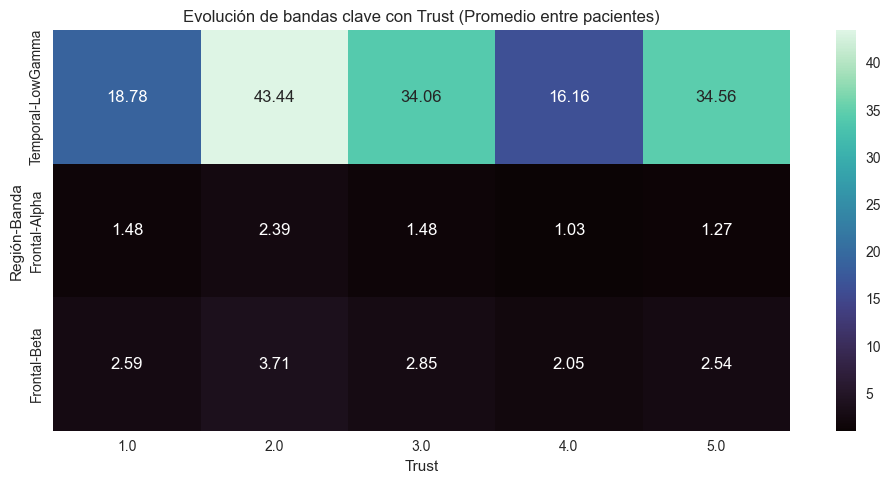

 Archivos exportados:
- promedios_globales_por_trust.csv
- estadistica_global_ANOVA_Kruskal.csv
- correlacion_Trust_PSD.csv


In [81]:
import glob


# 1. Cargar resultados de todos los pacientes

files = glob.glob("medias_por_trust_paciente*.csv")

dfs = []
for f in files:
    paciente = f.split("paciente")[-1].split(".")[0]
    df = pd.read_csv(f, index_col=0)
    dfs.append(df)

# Combinar con jerarquía: Paciente (nivel 0) y Trust (nivel 1)
combined = pd.concat(dfs, keys=range(1, len(dfs)+1), names=["Paciente", "Trust"])

print(f"Archivos cargados: {len(files)} pacientes")
print(f"Tamaño total del DataFrame combinado: {combined.shape}")


# 2. Calcular promedio global por Trust (solo numéricas)

numeric_cols = combined.select_dtypes(include="number").columns
mean_group = combined.groupby("Trust")[numeric_cols].mean()

plt.figure(figsize=(12,6))
sns.heatmap(mean_group.T, cmap="mako", annot=True, fmt=".1f")
plt.title("Media PSD por Región-Banda y Trust (Promedio entre pacientes)")
plt.xlabel("Trust")
plt.ylabel("Región-Banda")
plt.tight_layout()
plt.show()



# 3. Tests estadísticos globales (ANOVA y Kruskal)

stats_results = []
for col in mean_group.columns:
    groups = [combined.loc[:, col].xs(t, level="Trust") for t in mean_group.index]
    try:
        f, p_anova = f_oneway(*groups)
    except:
        p_anova = None
    try:
        h, p_kw = kruskal(*groups)
    except:
        p_kw = None
    stats_results.append({"Feature": col, "ANOVA_p": p_anova, "Kruskal_p": p_kw})

df_stats = pd.DataFrame(stats_results).sort_values("Kruskal_p")
df_stats.to_csv("estadistica_global_ANOVA_Kruskal.csv", index=False)
print("\n=== Top 10 diferencias significativas (Kruskal) ===")
print(df_stats.head(10))


# 4. Correlación Trust–PSD (lineal)

corrs = []
for col in mean_group.columns:
    corr = mean_group.index.to_series().corr(mean_group[col])
    corrs.append({"Feature": col, "Correlation": corr})

df_corr = pd.DataFrame(corrs).sort_values("Correlation", ascending=False)
df_corr.to_csv("correlacion_Trust_PSD.csv", index=False)
print("\n=== Correlaciones más altas ===")
print(df_corr.head(10))


# 5. Visualización de bandas clave

features_key = ["Temporal-LowGamma", "Frontal-Alpha", "Frontal-Beta"]
valid_features = [f for f in features_key if f in mean_group.columns]

plt.figure(figsize=(10,5))
sns.heatmap(mean_group[valid_features].T, cmap="mako", annot=True, fmt=".2f")
plt.title("Evolución de bandas clave con Trust (Promedio entre pacientes)")
plt.xlabel("Trust")
plt.ylabel("Región-Banda")
plt.tight_layout()
plt.show()


# 6. PCA y clustering de pacientes

X = combined.groupby("Paciente").mean()
X_scaled = StandardScaler().fit_transform(X)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
km = KMeans(n_clusters=2, random_state=42, n_init=10).fit(X_scaled)



# 7. Guardar resultados combinados

mean_group.to_csv("promedios_globales_por_trust.csv")
print(" Archivos exportados:")
print("- promedios_globales_por_trust.csv")
print("- estadistica_global_ANOVA_Kruskal.csv")
print("- correlacion_Trust_PSD.csv")


In [ ]:

#  ESTUDIO ESTADÍSTICO GLOBAL (TRUST 1–5)


plt.style.use("dark_background")

# Asegúrate de tener `combined` en memoria
# (output del paso anterior con todos los pacientes cargados)
print(f"Tamaño del DataFrame combinado: {combined.shape}")

# Usamos solo columnas numéricas
numeric_cols = combined.select_dtypes(include="number").columns


# 1. VARIABILIDAD GLOBAL POR BANDA / VARIANZA MEDIA
bandas = [c.split("-")[1] for c in numeric_cols]
band_stats = pd.DataFrame({
    "Banda": bandas,
    "Varianza": combined[numeric_cols].var().values,
    "Media_global": combined[numeric_cols].mean().values
})
band_stats = band_stats.groupby("Banda").mean().sort_values("Varianza", ascending=False)
print("\n=== VARIABILIDAD GLOBAL POR BANDA ===")
print(band_stats)

plt.figure(figsize=(8,4))
sns.barplot(data=band_stats.reset_index(), x="Banda", y="Varianza", hue="Banda", palette="viridis", legend=False)
plt.title("Variabilidad media por banda (Trust 1–5)")
plt.show()


# 4. CORRELACIÓN ENTRE REGIONES/BANDAS
corr = mean_group.corr()
plt.figure(figsize=(10,6))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Correlación entre regiones/bandas (promedio pacientes)")
plt.tight_layout()
plt.show()


Usando 19 features LowGamma: ['ch1-LowGamma-PSD', 'ch2-LowGamma-PSD', 'ch3-LowGamma-PSD', 'ch4-LowGamma-PSD', 'ch5-LowGamma-PSD', 'ch6-LowGamma-PSD', 'ch7-LowGamma-PSD', 'ch8-LowGamma-PSD', 'ch9-LowGamma-PSD', 'ch10-LowGamma-PSD', 'ch11-LowGamma-PSD', 'ch12-LowGamma-PSD', 'ch13-LowGamma-PSD', 'ch14-LowGamma-PSD', 'ch15-LowGamma-PSD', 'ch16-LowGamma-PSD', 'ch17-LowGamma-PSD', 'ch18-LowGamma-PSD', 'ch19-LowGamma-PSD']
K=2 | ARI=0.097 | AMI=0.054
K=3 | ARI=0.033 | AMI=0.032
K=4 | ARI=0.087 | AMI=0.057
K=5 | ARI=0.089 | AMI=0.055
K=6 | ARI=0.092 | AMI=0.061
 Mejor número de clusters según ARI: K=2


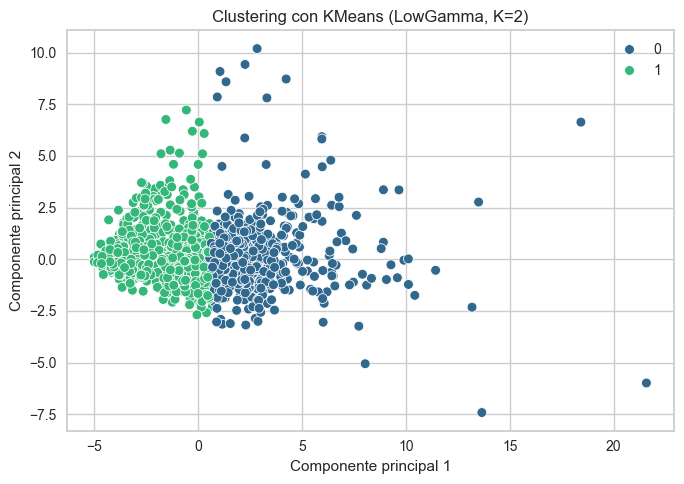


=== Distribución (%) de Trust real por cluster ===
col_0     0     1
Trust            
2.0    61.5  38.5
3.0    47.5  52.5
4.0    36.2  63.8
5.0    18.1  81.9


In [83]:

# 1.Cargar y preparar datos

df = pd.read_csv("/Users/luciarebolledo/PycharmProjects/TFG_practicas_final/eeg_features_session01_binarias/eeg_features_10.csv") 
# Filtrar solo columnas de PSD que sean LowGamma
lowgamma_cols = [c for c in df.columns if "-LowGamma-PSD" in c]

# Eliminar filas sin Trust o sin datos válidos
df_clean = df.dropna(subset=["Trust"] + lowgamma_cols).copy()

# Extraer matriz de características y variable objetivo
X = df_clean[lowgamma_cols]
y = df_clean["Trust"]

# Escalado de variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Usando {len(lowgamma_cols)} features LowGamma: {lowgamma_cols}")


# 2.Clustering con KMeans (k=2..6)

results = []
for k in range(2, 7):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=20)
    labels = kmeans.fit_predict(X_scaled)
    
    # Evaluación con métricas externas
    ari = adjusted_rand_score(y, labels)
    ami = adjusted_mutual_info_score(y, labels)
    
    results.append((k, ari, ami))
    print(f"K={k} | ARI={ari:.3f} | AMI={ami:.3f}")


# 3. Visualización PCA de la mejor solución

best_k = max(results, key=lambda x: x[1])[0] 
print(f" Mejor número de clusters según ARI: K={best_k}")

kmeans_best = KMeans(n_clusters=best_k, random_state=42, n_init=20)
labels_best = kmeans_best.fit_predict(X_scaled)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(7,5))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=labels_best, palette="viridis", s=50)
plt.title(f"Clustering con KMeans (LowGamma, K={best_k})")
plt.xlabel("Componente principal 1")
plt.ylabel("Componente principal 2")
plt.tight_layout()
plt.show()


# 4. Comparar clusters vs Trust real

cross_tab = pd.crosstab(df_clean["Trust"], labels_best, normalize='index') * 100
print("\n=== Distribución (%) de Trust real por cluster ===")
print(cross_tab.round(1))


Usando 19 columnas PSD de bandas: ['LowGamma']
K=2 | ARI=0.097 | AMI=0.054
K=3 | ARI=0.033 | AMI=0.032
K=4 | ARI=0.081 | AMI=0.059
K=5 | ARI=0.089 | AMI=0.055
K=6 | ARI=0.092 | AMI=0.061
 Mejor número de clusters según ARI: K=2


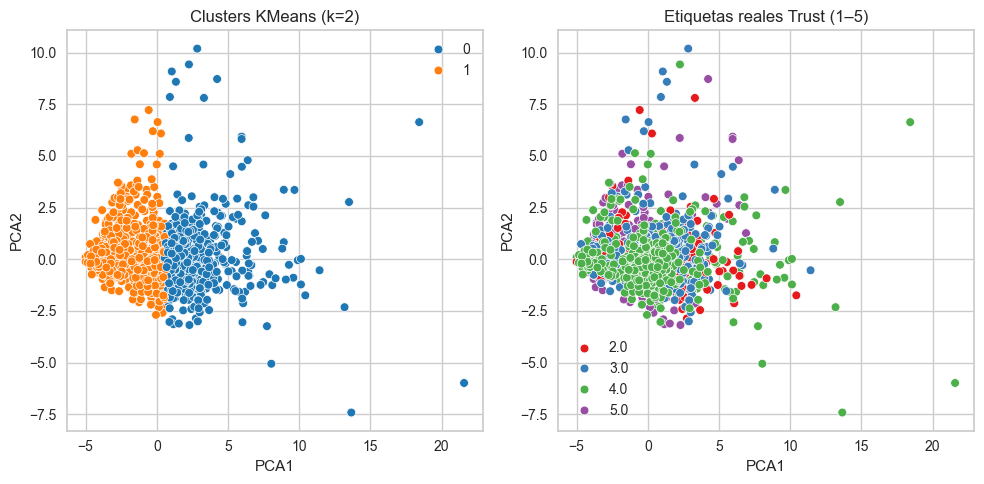


=== Distribución (%) de Trust real por cluster ===
col_0     0     1
Trust            
2.0    61.5  38.5
3.0    47.5  52.5
4.0    36.2  63.8
5.0    18.1  81.9


In [84]:

# 2. Seleccionar solo bandas relevantes

bands_keep = ["LowGamma"]
psd_cols = [c for c in df.columns if "-PSD" in c and any(b in c for b in bands_keep)]

print(f"Usando {len(psd_cols)} columnas PSD de bandas: {bands_keep}")


# 3. Limpiar y preparar datos

df_clean = df.dropna(subset=["Trust"] + psd_cols).copy()
X = df_clean[psd_cols].values
y = df_clean["Trust"].values

# Reemplazar posibles NaN en los features
X = np.nan_to_num(X, nan=np.nanmean(X))

# Escalar los datos
X_scaled = StandardScaler().fit_transform(X)


# 4. KMeans (K=2..6)

results = []
for k in range(2, 7):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)

    ari = adjusted_rand_score(y, labels)
    ami = adjusted_mutual_info_score(y, labels)
    results.append((k, ari, ami))
    print(f"K={k} | ARI={ari:.3f} | AMI={ami:.3f}")


# 5. Visualización con PCA

best_k = max(results, key=lambda x: x[1])[0]
print(f" Mejor número de clusters según ARI: K={best_k}")

km_best = KMeans(n_clusters=best_k, random_state=42, n_init=10)
labels_best = km_best.fit_predict(X_scaled)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 5))

# Clusters detectados por KMeans
plt.subplot(1, 2, 1)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels_best, palette="tab10", s=40)
plt.title(f"Clusters KMeans (k={best_k})")
plt.xlabel("PCA1")
plt.ylabel("PCA2")

# Etiquetas reales de Trust
plt.subplot(1, 2, 2)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette="Set1", s=40)
plt.title("Etiquetas reales Trust (1–5)")
plt.xlabel("PCA1")
plt.ylabel("PCA2")

plt.tight_layout()
plt.show()


# 6. Distribución de Trust por cluster

cross_tab = pd.crosstab(df_clean["Trust"], labels_best, normalize="index") * 100
print("\n=== Distribución (%) de Trust real por cluster ===")
print(cross_tab.round(1))


Usando 57 columnas PSD de bandas: ['LowGamma', 'Beta', 'Theta']
K=2 | ARI=-0.002 | AMI=0.006
K=3 | ARI=-0.000 | AMI=0.003
K=4 | ARI=0.044 | AMI=0.024
K=5 | ARI=0.036 | AMI=0.022
K=6 | ARI=0.024 | AMI=0.017
Mejor número de clusters según ARI: K=4


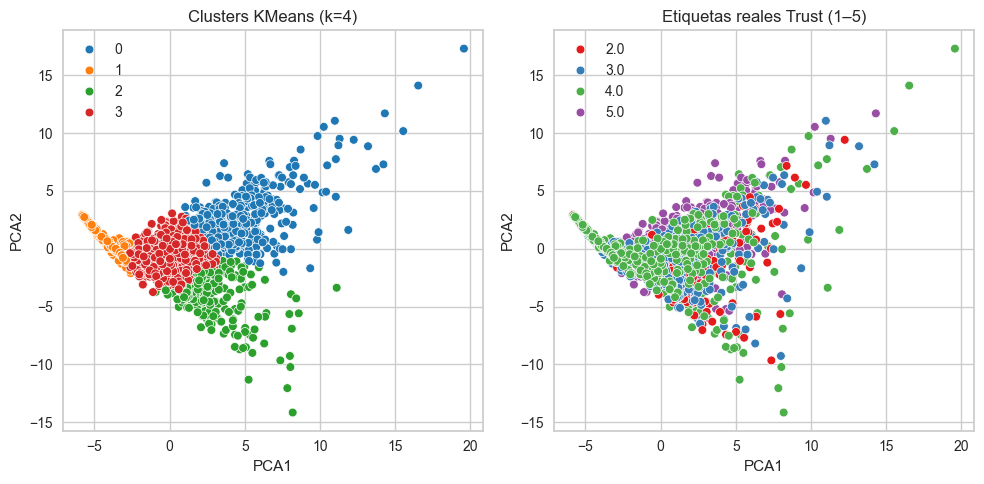


=== Distribución (%) de Trust real por cluster ===
col_0     0     1     2     3
Trust                        
2.0    20.5  20.5  24.5  34.5
3.0    18.8  22.8  15.5  43.0
4.0    17.8  31.0  13.6  37.6
5.0    19.7  23.1   3.8  53.4


In [85]:

# 2. Seleccionar solo bandas relevantes

bands_keep = ["LowGamma", "Beta", "Theta"]
psd_cols = [c for c in df.columns if "-PSD" in c and any(b in c for b in bands_keep)]

print(f"Usando {len(psd_cols)} columnas PSD de bandas: {bands_keep}")


# 3. Limpiar y preparar datos

df_clean = df.dropna(subset=["Trust"] + psd_cols).copy()
X = df_clean[psd_cols].values
y = df_clean["Trust"].values

# Reemplazar posibles NaN en los features
X = np.nan_to_num(X, nan=np.nanmean(X))

# Escalar los datos
X_scaled = StandardScaler().fit_transform(X)


# 4. KMeans (K=2..6)

results = []
for k in range(2, 7):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)

    ari = adjusted_rand_score(y, labels)
    ami = adjusted_mutual_info_score(y, labels)
    results.append((k, ari, ami))
    print(f"K={k} | ARI={ari:.3f} | AMI={ami:.3f}")


# 5. Visualización con PCA

best_k = max(results, key=lambda x: x[1])[0]
print(f"Mejor número de clusters según ARI: K={best_k}")

km_best = KMeans(n_clusters=best_k, random_state=42, n_init=10)
labels_best = km_best.fit_predict(X_scaled)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 5))

# Clusters detectados por KMeans
plt.subplot(1, 2, 1)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels_best, palette="tab10", s=40)
plt.title(f"Clusters KMeans (k={best_k})")
plt.xlabel("PCA1")
plt.ylabel("PCA2")

# Etiquetas reales de Trust
plt.subplot(1, 2, 2)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette="Set1", s=40)
plt.title("Etiquetas reales Trust (1–5)")
plt.xlabel("PCA1")
plt.ylabel("PCA2")

plt.tight_layout()
plt.show()


# 6. Distribución de Trust por cluster

cross_tab = pd.crosstab(df_clean["Trust"], labels_best, normalize="index") * 100
print("\n=== Distribución (%) de Trust real por cluster ===")
print(cross_tab.round(1))


 ## Último análisis: Cruda -> PCA -> KMEAN o estudio estadistico


In [86]:
# Cargar el CSV
df = pd.read_csv("/Users/luciarebolledo/PycharmProjects/TFG_practicas_final/eeg_pp_4_labeled.csv")

# Mostrar resumen general
print(f"Dimensiones del dataset: {df.shape}")
print(f"Columnas detectadas: {list(df.columns)[:10]} ...")

#  Comprobar si hay NaN 
tiene_nan = df.isna().any().any()
print(f"\n¿Hay NaN en el dataset?: {tiene_nan}")

# Número total de NaN
print(f"Total de valores NaN: {df.isna().sum().sum()}")

# Mostrar columnas con NaN (si las hay)
cols_con_nan = df.columns[df.isna().any()].tolist()
if len(cols_con_nan) > 0:
    print("\nColumnas con NaN y cantidad de valores faltantes:")
    print(df[cols_con_nan].isna().sum().sort_values(ascending=False))
else:
    print(" No se encontraron columnas con valores NaN.")


Dimensiones del dataset: (97280, 21)
Columnas detectadas: ['latency', 'fp1', 'fp2', 'f7', 'f3', 'fz', 'f4', 'f8', 't7', 'c3'] ...

¿Hay NaN en el dataset?: True
Total de valores NaN: 28834

Columnas con NaN y cantidad de valores faltantes:
Trust    28834
dtype: int64


Dimensiones originales: (97280, 21)
Filas tras eliminar NaN en Trust: (68446, 21)


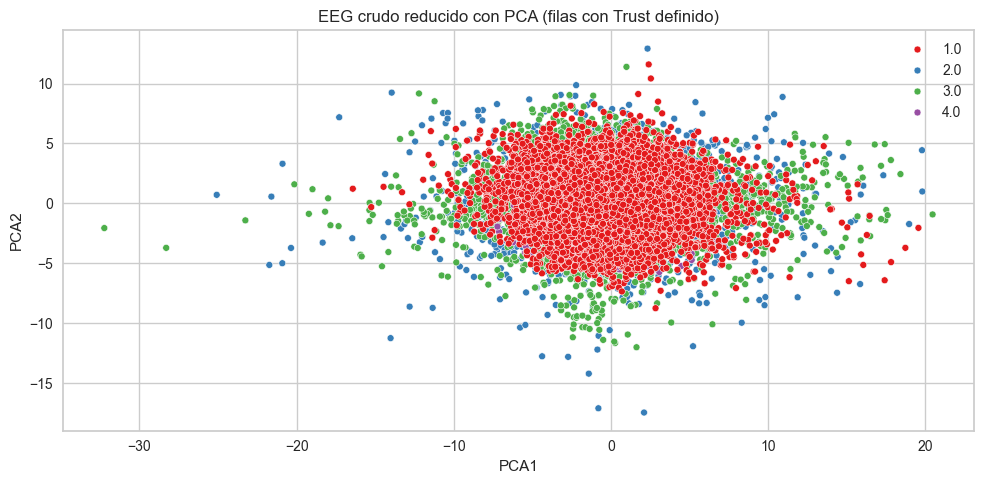

K=2 | ARI=0.000 | AMI=0.000
K=3 | ARI=0.000 | AMI=0.001
K=4 | ARI=-0.001 | AMI=0.001
K=5 | ARI=0.002 | AMI=0.003
K=6 | ARI=0.003 | AMI=0.003
 Mejor número de clusters según ARI: k=6


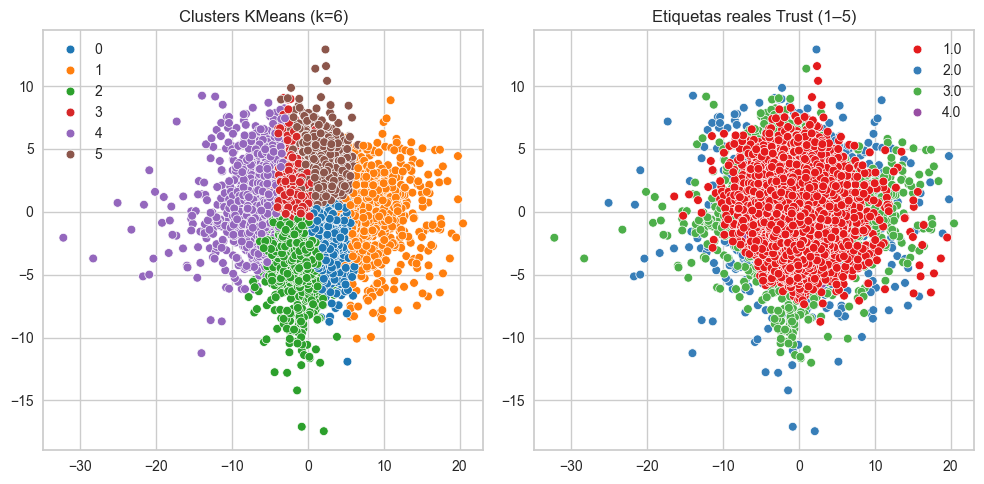

In [87]:


print(f"Dimensiones originales: {df.shape}")


# Eliminar filas sin Trust

df_clean = df.dropna(subset=["Trust"]).copy()
print(f"Filas tras eliminar NaN en Trust: {df_clean.shape}")


#  Separar features y etiquetas

X = df_clean.drop(columns=["Trust", "latency"], errors='ignore')  # quitamos latency si existe
y = df_clean["Trust"].values


# Escalar y aplicar PCA

X_scaled = StandardScaler().fit_transform(X)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10,5))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=y, palette="Set1", s=25)
plt.title("EEG crudo reducido con PCA (filas con Trust definido)")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.tight_layout()
plt.show()


#  KMeans no supervisado

results = []
for k in range(2, 7):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)

    ari = adjusted_rand_score(y, labels)
    ami = adjusted_mutual_info_score(y, labels)
    results.append((k, ari, ami))
    print(f"K={k} | ARI={ari:.3f} | AMI={ami:.3f}")

best_k = max(results, key=lambda x: x[1])[0]
print(f" Mejor número de clusters según ARI: k={best_k}")

# Visualización PCA + clusters
km_best = KMeans(n_clusters=best_k, random_state=42, n_init=10)
labels_best = km_best.fit_predict(X_scaled)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=labels_best, palette="tab10", s=40)
plt.title(f"Clusters KMeans (k={best_k})")

plt.subplot(1,2,2)
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=y, palette="Set1", s=40)
plt.title("Etiquetas reales Trust (1–5)")
plt.tight_layout()
plt.show()


Dimensiones originales: (97280, 21)
Filas tras eliminar NaN en Trust: (68446, 21)
K=2 | ARI=0.000 | AMI=0.000
K=3 | ARI=0.000 | AMI=0.001
K=4 | ARI=-0.001 | AMI=0.001
K=5 | ARI=0.000 | AMI=0.002
K=6 | ARI=0.003 | AMI=0.003
Mejor número de clusters según ARI: k=6


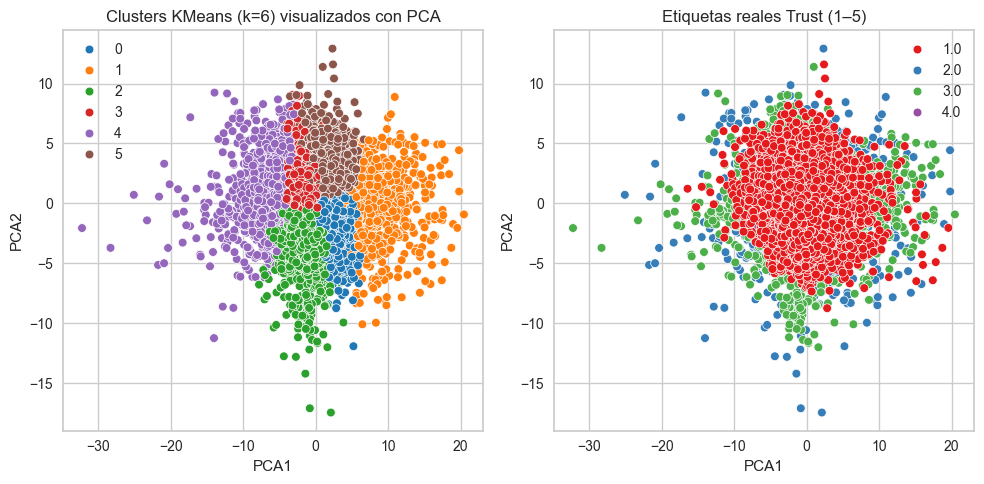


=== Distribución (%) de Trust real por cluster ===
col_0     0    1     2     3    4     5
Trust                                  
1.0    27.3  1.2  20.1  28.5  3.9  18.9
2.0    25.0  3.1  22.5  26.8  4.3  18.3
3.0    25.9  2.9  21.4  27.5  5.8  16.5
4.0    25.5  0.4  20.9  33.2  1.8  18.1


In [88]:

#  Cargar y limpiar datos

df = pd.read_csv("/Users/luciarebolledo/PycharmProjects/TFG_practicas_final/eeg_pp_4_labeled.csv")

print(f"Dimensiones originales: {df.shape}")

# Eliminar filas sin Trust
df_clean = df.dropna(subset=["Trust"]).copy()
print(f"Filas tras eliminar NaN en Trust: {df_clean.shape}")


#  Preparar features y etiquetas

X = df_clean.drop(columns=["Trust", "latency"], errors="ignore")
y = df_clean["Trust"].values

# Escalar
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


#  KMeans (sin PCA)

results = []
for k in range(2, 7):
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X_scaled)

    ari = adjusted_rand_score(y, labels)
    ami = adjusted_mutual_info_score(y, labels)
    results.append((k, ari, ami))
    print(f"K={k} | ARI={ari:.3f} | AMI={ami:.3f}")

# Escoger mejor k según ARI
best_k = max(results, key=lambda x: x[1])[0]
print(f"Mejor número de clusters según ARI: k={best_k}")


# Reajustar KMeans final con best_k

km_best = KMeans(n_clusters=best_k, random_state=42, n_init=10)
labels_best = km_best.fit_predict(X_scaled)


#  Reducir con PCA para visualizar

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10,5))

# Clusters detectados por KMeans (espacio PCA)
plt.subplot(1,2,1)
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=labels_best, palette="tab10", s=40)
plt.title(f"Clusters KMeans (k={best_k}) visualizados con PCA")
plt.xlabel("PCA1")
plt.ylabel("PCA2")

# Etiquetas reales de Trust
plt.subplot(1,2,2)
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=y, palette="Set1", s=40)
plt.title("Etiquetas reales Trust (1–5)")
plt.xlabel("PCA1")
plt.ylabel("PCA2")

plt.tight_layout()
plt.show()


#  Distribución de Trust por cluster

cross_tab = pd.crosstab(df_clean["Trust"], labels_best, normalize="index") * 100
print("\n=== Distribución (%) de Trust real por cluster ===")
print(cross_tab.round(1))
